In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
sns.set_theme()

## Desarrollo de posible metrica de desempeño
## Para ejecucion de codigo ir a seccion Naive_Aproach

In [ ]:
def logistic_function(x,tolerance = 1.):    
    return 1/ (1 + np.exp(-tolerance*x))
def diff_normalization(x,num_pixel_tol = 100):
    tolerance = (200/num_pixel_tol)/100
    return np.tanh(tolerance * x)
def diff_assignation(x): 
    return 1 - x

In [ ]:
x = np.linspace(0,10,10)
y = diff_normalization(x,10)
# print(y)
plt.plot(x,y)
plt.show()

In [ ]:
example_table = pd.read_csv('etiquetas.csv')
# example_table.head()

new_label_table = pd.read_csv('renombramiento_etiquetas.csv')
new_label_table = new_label_table.rename(columns = {'new_class' : 'class'})
new_label_table.head()

In [ ]:
new_label_table.loc[new_label_table['class'] == 'Descripciones', 'class'] = 'Etiqueta'

In [ ]:
example_table['xsize'] =  example_table['xmax'] - example_table['xmin']
example_table['ysize'] =  example_table['ymax'] - example_table['ymin']
print(example_table['xsize'].astype(float).mean() * 0.1 ,example_table['ysize'].astype(float).mean() * 0.1)

In [ ]:
sstr = 'model_CNN_tensorflow.keras'
sstr[:-6]

In [ ]:
def calculate_iou(box1, box2):
    """
    Calculates the IoU (Intersection over Union) between two bounding boxes.
    
    Arguments:
    box1 -- list or tuple containing [x1, y1, x2, y2] coordinates of the first bounding box
    box2 -- list or tuple containing [x1, y1, x2, y2] coordinates of the second bounding box
    
    Returns:
    iou -- float value representing the IoU between the two bounding boxes
    """
    # calculate the area of each bounding box
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # calculate the area of the intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # calculate the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # calculate the IoU
    iou = intersection_area / union_area
    
    return iou


def evaluate_object_detection(pred_boxes, true_boxes, iou_thresh):
    """
    Computes the average precision for object detection using IoU metric.
    
    Args:
    - pred_boxes (list of tuples): Predicted bounding boxes (x1, y1, x2, y2) for each object
    - true_boxes (list of tuples): Ground truth bounding boxes (x1, y1, x2, y2) for each object
    - iou_thresh (float): Threshold for determining a true positive detection
    
    Returns:
    - ap (float): Average precision for the given set of predictions and ground truth boxes
    """
    
    # Create a dictionary to store the number of true positives and false positives for each class
    tp = {}
    fp = {}
    for i in range(len(pred_boxes)):
        # Find the class of the predicted box (assuming all boxes have a class label)
        cls = pred_boxes[i][4]
        if cls not in tp:
            tp[cls] = 0
            fp[cls] = 0
        
        # Check if the predicted box overlaps with any of the ground truth boxes
        overlaps = []
        for j in range(len(true_boxes)):
            overlap = calculate_iou(pred_boxes[i], true_boxes[j])
            overlaps.append(overlap)
        
        # If there is at least one ground truth box with an IoU greater than the threshold, count it as a true positive
        max_overlap = max(overlaps)
        if max_overlap >= iou_thresh:
            tp[cls] += 1
        else:
            fp[cls] += 1
    
    # Compute precision and recall for each class
    precisions = {}
    recalls = {}
    for cls in tp:
        precisions[cls] = tp[cls] / (tp[cls] + fp[cls])
        recalls[cls] = tp[cls] / len([box for box in true_boxes if box[4] == cls])
    
    # Compute the average precision across all classes
    ap = sum(precisions.values()) / len(precisions)
    
    return ap


In [ ]:
def measuring_model_precision(table:pd.DataFrame,num_pixel_tol:int = 100):
    """vamos a calcular la precision del modelo pormedio de la evaluacion directa de la ubicacion de las cajas contenedoras generadas 
       y los labels asignados a dichas cajas, cada dato se encuentra apareado de manera apropiada.
       
       La evaluacion se ejecuta calculando la diferencia entre las coordenadas predichas por el modelo y las puestas a mano, esta diferencia se transforma
       por medio de una funcion logistica 

    Args:
        table (pd.DataFrame): tabla que aloja las posiciones de los labels de test y los arrojados por el modelo
        tolerance (float)  : 
    """
    score = 0
    same_label = True if table['class'] == table['predicted_class'] else False
    diff_posx = abs(table['xmin']-table['xmin_pred']) + abs(table['xmax']-table['xmax_pred'])
    diff_posy = abs(table['ymin']-table['ymin_pred']) + abs(table['ymax']-table['ymax_pred'])
    normalize_diff_posx = diff_normalization(diff_posx,num_pixel_tol = num_pixel_tol)
    normalize_diff_posy = diff_normalization(diff_posy,num_pixel_tol = num_pixel_tol)
    # score += diff_assignation(normalize_diff_posx) / 3
    # score += diff_assignation(normalize_diff_posy) / 3
    box_labeled = [table['xmin'],table['xmax'],table['ymin'],table['ymax']]
    box_pred = [table['xmin_pred'],table['xmax_pred'],table['ymin_pred'],table['ymax_pred']]
    score += evaluate_object_detection(box_labeled, box_pred, num_pixel_tol) / 2
    if same_label:
        score += 1 / 2
    table['score'] = score
    return table

In [ ]:
from drive.MyDrive.tesis.make_cfg import SAMPLE_DICT,make_cfg_file

# pytorc_config_values = [[3,3,3,3,3],[8,16,32,64,128],['same','same','same','same','same'],['relu','relu','relu','relu','relu'],[2,2,2,2,2],[3,3,3,3,3],['valid','valid','valid','valid','valid']]
# new_dict_pytorc_config_values = {}
# for k,nv in zip(SAMPLE_DICT.keys(),pytorc_config_values):
#     new_dict_pytorc_config_values[k] = nv
#     print(nv)

new_dict_pytorc_config_values =  {
                        'kernel_size_conv': [8,16,32,64], #, 2, 2, 2, 2
                        'filters': [3,3,3,3], #,16, 32, 64,128
                        'conv_padding': [2,2,2,2], #,1,1,1,1
                        'activation': ['relu','relu','relu','relu'], #, 'relu', 'relu', 'relu', 'relu'
                        'pool_size': [4,4,4,4], #, 2, 2, 2, 2
                        'conv_stride': [1,1,1,1], #, 1, 1, 1, 1
                        'pool_stride': [3,3,3,3], #, 3, 3, 3, 3
                        'pool_padding': [2,2,2,2], #,1,1,1,1
                        'padding_mode_conv' : ['zeros','zeros','zeros','zeros'], # ,'zeros','zeros','zeros','zeros' zeros', 'reflect', 'replicate' or 'circular'

                        }



make_cfg_file(new_dict_pytorc_config_values,'torch_simple.cfg')

In [ ]:
import pandas as pd
def contar_clases_dataset(table:pd.DataFrame):
    """crea una colunma llamada class_count con la cantidad de etiquetas diferentes en la imagen

    Args:
        table (pd.DataFrame): tabla de datos de las imagenes
    """
    # table['class_count'] = ''
    l = {}
    for label in table.class_name.unique():
        table_filter = table.loc[table.class_name == label]
        labelCounr = table_filter.shape[0]
        totalLabels = table.shape[0]
        l[label] = labelCounr/totalLabels
    
    return l 

In [ ]:
from utils.paths import get_project_labels
unLabels = get_project_labels('etiquetas.csv')
MELULabels = get_project_labels('etiquetas_MELU.csv')
unLabelsTable = pd.read_csv(unLabels)
MELULabelsTable = pd.read_csv(MELULabels)

In [ ]:
l1 = contar_clases_dataset(unLabelsTable)
l2 = contar_clases_dataset(MELULabelsTable)

In [ ]:
l1

In [ ]:
sum(list(l1.values()))

In [ ]:
def draw_labels_distribution(table:pd.DataFrame):
    """dibuja la distribucion de las etiquetas en la tabla

    Args:
        table (pd.DataFrame): tabla de datos de las imagenes
    """
    l = contar_clases_dataset(table)
    plt.bar(l.keys(),l.values())
    plt.show()

In [ ]:

df1 = pd.DataFrame.from_dict(l1,orient='index').reset_index().rename(columns = {'index':'class',0:'percentage'})

In [ ]:
df1

In [ ]:
df2

In [ ]:
df2 = pd.DataFrame.from_dict(l2,orient='index').reset_index().rename(columns = {'index':'class',0:'percentage'})

In [ ]:
import seaborn as sns   
print(list(sns.color_palette('husl', 10)))

In [ ]:
print(df1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette('Dark2', 10)
# Create the histogram plot
ax = sns.barplot(data=df1,  palette=palette, x = 'class',hue='class', y='percentage')
# ax.set(title="set datos un")
ax.set(xlabel='Class', ylabel='Percentage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



In [ ]:


ax = sns.barplot(data=df2,  palette=palette, x = 'class',hue='class', y='percentage')
ax.set(title="set datos MELU")
ax.set(xlabel='clases', ylabel='porcentaje')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
from utils.model_evaluator import PytorchEvaluator


In [ ]:
def train_balance_table_compilation(table:pd.DataFrame, fraction :float = 0.6):
    """" Genera una tabla de imagenes con sus etiquetas y posiciones de tal manera que el conjunto resultante sea el mas balanceado posible 
    en terminos de tipos y numeros de etiquetas

    Args:
        table (pd.tableFrame): tabla de imagenes y etiquetas totales
    """
    tabla_contada = contar_clases_por_imagen(table)
    tabla_contada['class_ratio'] = tabla_contada['class_count'] / tabla_contada['class_count'].max()
    # print(tabla_contada.loc[tabla_contada.class_count == tabla_contada.label_count])
    # print(tabla_contada[tabla_contada.class_ratio.ge(1)])
    tabla_contada.loc[tabla_contada.class_count == tabla_contada.label_count, 'class_ratio'] += tabla_contada['label_count'] / tabla_contada['class_count'].max()
    tabla_contada.loc[tabla_contada.class_count.lt(tabla_contada.label_count * 0.66), 'class_ratio'] = 0 #tabla_contada['label_count'] / tabla_contada['class_count'].max()
    tabla_contada_simplificada = tabla_contada.drop_duplicates(subset = 'filename').reset_index()
    # print(tabla_contada_simplificada[tabla_contada_simplificada.class_ratio.ge(1)])
    train_sample = tabla_contada_simplificada.sample(weights = tabla_contada_simplificada['class_ratio'],frac = fraction)
    # print(train_sample[train_sample.class_ratio.ge(1)])
    table_train_sample = table.loc[table.filename.isin(train_sample.filename)].reset_index(drop = True)
    table_test_sample = table.loc[~table.filename.isin(train_sample.filename)].reset_index(drop = True)
    return table_train_sample,table_test_sample
    

In [ ]:
train_set,test_set = train_balance_table_compilation(new_label_table)

In [ ]:
sns.histplot(data = train_set, y = "class").set(title = "set entremamiento")
plt.tight_layout()

In [ ]:
sns.histplot(data = test_set, y = "class").set(title = "set testeo")
plt.tight_layout()

In [ ]:
meludata = pd.read_csv('etiquetas_MELU.csv')

In [ ]:
sns.histplot(data = new_label_table, y = "class").set(title = "set datos originales")
plt.tight_layout()

## Naive Aproach

In [ ]:
import numpy as np
import pandas as pd

import os


In [ ]:
def assign_number_according_to_class(series : pd.Series):
    hash_dict = {}
    for i,label in enumerate(series.unique()):
        hash_dict[label] = i
    return hash_dict

def put_hash_column(table : pd.DataFrame):
    hash_dict = assign_number_according_to_class(table['class_name'])
    for k,v in hash_dict.items():
        table.loc[table.class_name == k,'class_hash'] = int(v)
    return table

# Yolo txt annotation creation

In [ ]:

data_table = pd.read_csv('etiquetas.csv')
data_table = data_table.drop(columns = 'valid_path')
data_table = put_hash_column(data_table)

yolo_annotation_folder = os.path.join(os.getcwd(),'data','labels')

if not os.path.exists(yolo_annotation_folder):
    os.makedirs(yolo_annotation_folder)

annotations_grouped_by_image = data_table.groupby("filename")

for i,file_table in annotations_grouped_by_image:
    with open(f"{os.path.join(yolo_annotation_folder,i[:-4])}.txt","w+") as file:
        for j,row in file_table.iterrows():
            class_width = row["xmax"]-row["xmin"]
            class_height = row["ymax"]-row["ymin"]
            line = f'{int(row["class_hash"])} {(row["xmin"] + (0.5 * class_width))/row["width"]} {(row["ymin"] + (0.5 * class_height))/row["height"]} {class_width/row["width"]} {class_height/row["height"]}\n'
            file.write(line)
        

# TRANSFORMACION DE DATOS A COCO FORMAT

In [ ]:
from dataclasses import dataclass, field
from typing import Dict, List 
import functools

@dataclass 
class JsonCOCOFormatter:
    
    ##### creacion de formato
    info: Dict = field(init = False, default_factory =  dict),
    licenses: List[Dict] = field(default_factory = list),
    images: List[Dict] = field(default_factory = list),
    annotations: List[Dict] = field(default_factory = list),
    categories: List[Dict] = field(default_factory = list), 
    # segment_info: List[Dict] = field(default_factory = list), 
    
    ##### input variables
    url : str = field(default="None")
    id_lincense : int = field(default = None)

    lincense_name : str = field(default = "generic_lincense")
    file_name : str = field(default = "")
    coco_url : str = field(default = "None")
    height : int = field(default = None)
    width : int = field(default = None)
    date_captured : str = field(default = "None")
    flickr_url : str = field(default = "None")
    id_photo : int = field(default = None)
 
    category_name : str = field(default = "")
    subcategory_name : str = field(default = "")
    id_category : int = field(default = None)
 
    segmentation : List[int] = field(default_factory = list)
    is_crowd : str = field(default = "FALSE")
    bbox : List[int] = field(default_factory = list)
    id_annotation : int = field(default = None)
    SAVE_PATH : str = field(default = os.path.join(os.getcwd(),'annotations'))
    FILE_NAME : str = field(default = 'dataset.json')
   

    def __post_init__(self):
        self.info = {
                    "year": "2023",
                    "version": "1.0",
                    "description": "National Herbarium DataSet",
                    "contributor": "DataLab Universidad Nacional de Colombia",
                    "url": "",
                    "date_created": "2023/04/20"
                    }
    
    def make_lincense(self):
        return self.licenses.append({
                "url": self.url,
                "id": self.id_lincense,
                "name": self.lincense_name
            })
        
    def make_image(self):
        condition = True
        for x in self.images:
            if self.file_name in x.values():
                condition = False
        
        if condition:
            return self.images.append({
                "license": self.id_lincense,
                "file_name": self.file_name,
                "coco_url": self.coco_url,
                "height": self.height,
                "width": self.width,
                "date_captured": self.date_captured,
                "flickr_url": self.flickr_url,
                "id": self.id_photo,
                # "annotations" : self.annotations
                })
        
    def make_category(self):
        condition = True
        for x in self.categories:
            if self.subcategory_name in x.values():
                condition = False
        if condition:
            return self.categories.append({
                    "supercategory": self.category_name,
                    "id": self.id_category,
                    "name": self.subcategory_name
                })
            
    def make_annotation(self):
        return self.annotations.append({
                "segmentation": self.segmentation,
                "area": self.height * self.width,
                "iscrowd": self.is_crowd,
                "image_id": self.id_photo,
                "bbox": self.bbox,
                "category_id": self.id_category,
                "id": self.id_annotation
            })
            
    def to_file(self):
        target_keys =['info','licenses','images','annotations','categories']
        target_dict = {key: value for key, value in self.__dict__.items() if key in target_keys}
        if not os.path.exists(self.SAVE_PATH):
            os.makedirs(self.SAVE_PATH)
        with open(os.path.join(self.SAVE_PATH,self.FILE_NAME),'w+') as file:
            # file.write(str(target_dict).replace('"',"'").strip('"<>()'))
            file.write(str(target_dict).replace("'",'"').strip("'<>()"))
    
    

In [ ]:
data_table = pd.read_csv('etiquetas.csv')
data_table.head()

In [ ]:
data_table = pd.read_csv('etiquetas.csv')
data_table = data_table.drop(columns = 'valid_path')
data_table = put_hash_column(data_table)

def bbox_COCO_format(bbox:list[float])->list[float]:
    x_center = 0.5 * (bbox[0] + bbox[2])
    y_center = 0.5 * (bbox[1] + bbox[3])
    width = np.abs(bbox[2] - bbox[0])
    height = np.abs(bbox[3] - bbox[1])
    return [x_center,y_center,width,height]

def bbox_de_COCO_format(bbox:list[float])->list[float]:
    x_min = bbox[0] - (0.5 * bbox[2])
    y_min = bbox[1] - (0.5 * bbox[3])
    x_max = x_min + bbox[2]
    y_max = y_min + bbox[3]
    return [x_min,y_min,x_max,y_max]

file_information_gather = data_table.groupby('filename')
id_picture = 0
id_licencia = 0
imagenes , licensias, anotaciones, categorias = [],[],[],[]
for picture_name, sub_table in file_information_gather:
    id_picture += 1
    id_licencia += 1
    id_anotacion = 0
    picture_path = os.path.abspath(picture_name) #os.path.join(os.getcwd(),'data','imagenes', picture_name)
    single_photo_data = functools.partial(JsonCOCOFormatter,images=imagenes,licenses=licensias,annotations=anotaciones,categories=categorias,file_name=picture_path,height=sub_table.height.unique()[0],width=sub_table.width.unique()[0],id_lincense = id_licencia, id_photo = id_picture)
    for i,row in sub_table.iterrows():
        id_anotacion += 1
        bbox_paste = bbox_COCO_format([row["xmin"],row["ymin"],row['xmax'],row['ymax']]) # coordenadas para dar puntos medios y tamaños de las cajas[(row["xmin"] + (0.5 * class_width))/row["width"],(row["ymin"] + (0.5 * class_height))/row["height"],class_width/row["width"],class_height/row["height"]]#
        whole_data = single_photo_data(category_name = "etiquetas", subcategory_name = row['class_name'],segmentation = ["empty"],bbox = bbox_paste,id_annotation=id_anotacion,id_category=row['class_hash'])
        whole_data.make_lincense()
        whole_data.make_category()
        whole_data.make_annotation()
        whole_data.make_image()
        

In [ ]:
whole_data.to_file()#.to_json()

In [ ]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.print(physical_devices)


if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

# EJEMPLO DE CREACION NUEVA ARQUITECTURA

In [ ]:
from make_cfg import SAMPLE_DICT,make_cfg_file

new_arch_values = [[64,192,128,512,1024],[7,3,3,3,3],['same','same','same','same','same'],['relu','relu','relu','relu','relu'],[2,2,2,2,2],[None,None,None,None,None],['valid','valid','valid','valid','valid']]
new_dict_arch = {}
for k,nv in zip(SAMPLE_DICT.keys(),new_arch_values):
    new_dict_arch[k] = nv

make_cfg_file(new_dict_arch,'config/yolo_simple','json')


In [ ]:
make_cfg_file(SAMPLE_DICT,'config/default_config','json')

In [ ]:
!rm config/torch_simple.cfg

In [ ]:
from make_cfg import SAMPLE_DICT,make_cfg_file

pytorc_config_values = [[3,3,3,3,3],[128,64,32,16,8],['valid','valid','valid','valid','valid'],['relu','relu','relu','relu','relu'],[2,2,2,2,2],[None,None,None,None,None],['valid','valid','valid','valid','valid']]
new_dict_pytorc_config_values = {}
for k,nv in zip(SAMPLE_DICT.keys(),pytorc_config_values):
    new_dict_pytorc_config_values[k] = nv

make_cfg_file(new_dict_pytorc_config_values,'config/torch_simple.cfg')


In [ ]:
def joinEntriesOfList(lista:list,juntionSize:int = 2):
    jointList = []
    for leftSide in range(0,len(lista),juntionSize):
        rightSide = leftSide + juntionSize
        jointList.append(lista[leftSide:rightSide])
    return jointList
        

In [ ]:
l1 = [x for x in range(100)]
l2 = joinEntriesOfList(l1,3)
l3 = joinEntriesOfList(l2)

In [ ]:
l3

In [ ]:
!python naive_model_torch.py

# Ejecucion de codigo

In [ ]:
!python naive_model.py --batch_size 50 --epochs 200 --model_structure config/yolo_simple.cfg --save_model YoloSimpBatch50Epochs200 

# Ejecucion arquitectura default

In [ ]:
!python naive_model.py --batch_size 50 --device 'GPU' --epochs 200 --save_model BaseEpoch200Batch50

# lectura de modelo entrenado

In [ ]:
import tensorflow as tf
from models import CustomIoUMetric
custom_objects = {"CustomIoUMetric": CustomIoUMetric}

scanned_model = tf.keras.models.load_model('models/CNN_modeltest1',custom_objects=custom_objects)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from typing import Callable
# read image
from utils.paths import get_project_data_MELU_dir, get_project_data_UN_dir,get_project_results


path1 = get_project_data_UN_dir('imagenes')
path2 = get_project_data_MELU_dir('trian/images')

def monochromaticIntensityHistogram(path : str,save:bool = False,show:bool = False):
    imageList = os.listdir(path)
    savePath = get_project_results(f'images/histograms/')
    os.makedirs(savePath,exist_ok=True)
    for image in imageList[:5]:
        im = cv2.imread(os.path.join(path,image))
        vals = im.mean(axis=2).flatten()
        counts, bins = np.histogram(vals, range(257))
        plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
        plt.xlim([-0.5, 255.5])
        plt.title('Histogram for intensity (grey scale) picture')
        plt.xlabel('Intensity value')
        plt.ylabel('Pixel Count')
        if save:
            plt.savefig(os.path.join(savePath,f'{image[:-4]}_histogram'),format = 'png')
            with open(os.path.join(savePath,f'{image[:-4]}_histogram.txt'),'w+') as file:
                file.write(str({'bins':bins,'counts':counts}))
        if show:
            plt.show()

In [ ]:
from utils.graphics import monochromaticIntensityHistogram,RGBhitogram
from utils.paths import get_project_data_MELU_dir, get_project_data_UN_dir,get_project_results

path1 = get_project_data_UN_dir('imagenes')
path2 = get_project_data_MELU_dir('trian/images')
# monochromaticIntensityHistogram(path=path1,save=True,show=False)
RGBhitogram(path=path1,save=True,show=False)


In [ ]:
monochromaticIntensityHistogram(path1,save=True)

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
image_un = get_project_data_UN_dir('imagenes')
imageList = os.listdir(image_un)
for image in imageList[:5]:
    img = cv2.imread(get_project_data_UN_dir(f'imagenes/{image}'))
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
   
    plt.title('Histogram for color scale picture')
    plt.show()

# while True:
#     k = cv2.waitKey(0) & 0xFF     
#     if k == 27: break  
# cv2.destroyAllWindows()   

# evaluacion del modelo

In [ ]:
from utils import get_maximun_number_of_annotation_in_set, train_batch_consolidation, read_data, image_test_set, image_train_set
import pickle


IMG_SHAPE = (500, 500)
total_test_images = []
total_test_targets = []

images,annotations,_,_ = read_data()

test_bites = open('sets/test_image_set','rb')
test_images = pickle.load(test_bites)#image_test_set(images,train_images)

max_n_boxes_test = get_maximun_number_of_annotation_in_set(annotations,images)
images_for_test , test_targets = train_batch_consolidation(test_images,total_test_images,annotations,total_test_targets,max_n_boxes_test,IMG_SHAPE)
images_for_test = tf.cast(images_for_test, dtype=tf.float32)
evaluations = scanned_model.evaluate(images_for_test,test_targets,batch_size=len(images_for_test))

MELUB102930a_sp64414160451423553680_medium image
MELUA002114a_sp64023357247815722155_medium annotation

In [ ]:
import yaml

def display_yaml_content(yaml_file:yaml,return_data:bool = True)->dict:
    with open(yaml_file) as file:
        documents = yaml.full_load(file)
        for item,doc in documents.items():
            print(item,':',doc)
    return documents if return_data else None 
        

0 small database label
1 handwritten data
2 stamp
3 annotation label
4 scale
5 swing tag
6 full database label
7 database label
8 swatch
9 institutional label
10 number(ii)

In [ ]:
def confg_yaml(train_path:str,validation_path:str,categories:dict,config_file_name:str = 'default')->None:
    '''
    creates a configuration file for the ultralytics yolo package, recives the path to training
    and validation images along with a dictionary containing the desired target classes
    '''

    config_dict = {
        'train':train_path,
        'val': validation_path,
        'names' : categories
        }
    
    with open(f'{config_file_name}.yaml' , 'w') as config_file:
        yaml.dump(config_dict,config_file,default_flow_style=False)


In [ ]:
import json
import os
coco_file_path = os.path.join(os.getcwd(),'annotations','dataset.json')
coco_file = open(coco_file_path, 'r')
coco_file_open = json.load(coco_file)

In [ ]:
coco_file_open

In [ ]:
import datetime as dt
dt.datetime.now().month

In [ ]:
# from drive.MyDrive.tesis.COCO_formatter import bbox_de_COCO_format,bbox_COCO_format
from cv2 import imread, imshow, rectangle,putText,FONT_HERSHEY_SIMPLEX
from google.colab.patches import cv2_imshow

def draw_bbox(image_path:str,ids:list[int],coordinates:list[list[float]],cloud:bool=False):
    image_to_visualize = image_path #os.path.join(IMG_MEL_PATH,image_max_name)
    img = imread(image_to_visualize)
    for id,coordinate in zip(ids,coordinates) :
        nc = bbox_de_COCO_format([float(x.replace('\n','')) for x in coordinate])
        rectangle(img,(int(nc[0]*img.shape[1]),int(nc[1]*img.shape[0])),((int(nc[2]*img.shape[1]),int(nc[3]*img.shape[0]))),(255,0,0),3)
        putText(img, id, (int(nc[0]*img.shape[1])-20,int(nc[1]*img.shape[0])+10), FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
    if cloud : cv2_imshow(img)
    else : imshow(img) 

In [ ]:
from make_cfg import make_cfg_file

new_dict_pytorc_config_values =  params = {
                                    'kernel_size_conv': [3, 3, 3, 3],
                                    'filters': [3, 3, 3, 3],  # Changed the first filter value from 3 to 16
                                    'conv_padding': [2, 2, 2, 2],
                                    'activation': ['relu', 'relu', 'relu', 'relu'],
                                    'pool_size': [4, 4, 4, 4],
                                    'conv_stride': [1, 1, 1, 1],
                                    'pool_stride': [3, 3, 3, 3],
                                    'pool_padding': [2, 2, 2, 2],
                                    'padding_mode_conv': ['zeros', 'zeros', 'zeros', 'zeros']
                                }

#{
#                         'kernel_size_conv': [8,16,32,64], #, 2, 2, 2, 2
#                         'filters': [3,3,3,3], #,16, 32, 64,128
#                         'conv_padding': [2,2,2,2], #,1,1,1,1
#                         'activation': ['relu','relu','relu','relu'], #, 'relu', 'relu', 'relu', 'relu'
#                         'pool_size': [4,4,4,4], #, 2, 2, 2, 2
#                         'conv_stride': [1,1,1,1], #, 1, 1, 1, 1
#                         'pool_stride': [3,3,3,3], #, 3, 3, 3, 3
#                         'pool_padding': [2,2,2,2], #,1,1,1,1
#                         'padding_mode_conv' : ['zeros','zeros','zeros','zeros'], # ,'zeros','zeros','zeros','zeros' zeros', 'reflect', 'replicate' or 'circular'

#                         }



make_cfg_file(new_dict_pytorc_config_values,'config/torch_simple','json')

In [ ]:
!rm config/torch_simple.json

In [ ]:
!python COCO_formatter.py

In [ ]:
!rm annotations/dataset.json

In [ ]:
import json
import os
#coco_file_path = os.path.join(os.getcwd(),'annotations','dataset.json')
coco_file = open('config/torch_simple.json', 'r')
coco_file_open = json.load(coco_file)

In [ ]:
coco_file_open

In [ ]:
for value in coco_file_open.values():
    [print(type(x)) for x in value]

In [ ]:
from cv2 import imread
import os
import numpy as np

base_path = '/Users/juanpablovargasacosta/herbario/data/imagenes/'
all_means = []
all_stds = []
for file in os.listdir(base_path):
    if file.endswith('.png'):
        image = imread(os.path.join(base_path,file))
        means_by_channels = np.mean(image,axis=(0,1))
        stds_by_channels = np.std(image,axis=(0,1))
        all_means.append(means_by_channels)
        all_stds.append(stds_by_channels)

arrange_means = np.stack(all_means)
arrange_stds = np.stack(all_stds)

print(np.mean(arrange_means,axis=0))
print(np.mean(arrange_stds,axis=0))

In [ ]:
def calculate_mean_std_per_channel(image_folder:str)->list[float]:
    all_means = []
    all_stds = []
    for file in os.listdir(image_folder):
        if file.endswith('.png'):
            image = imread(os.path.join(image_folder,file))
            means_by_channels = np.mean(image,axis=(0,1))
            stds_by_channels = np.std(image,axis=(0,1))
            all_means.append(means_by_channels)
            all_stds.append(stds_by_channels)

    arrange_means = np.stack(all_means)
    arrange_stds = np.stack(all_stds)

    return [np.mean(arrange_means,axis=0),np.mean(arrange_stds,axis=0)]


In [ ]:
l = calculate_mean_std_per_channel('/Users/juanpablovargasacosta/herbario/data/imagenes/')


In [ ]:
def read_cache_file_bytes(fileName:str)->bytes:
    with open(fileName,'rb') as file:
        contenido = file.read()
    return contenido

In [ ]:
import json
def read_cache_file_json(fileName:str):
    """Reads the content of the cache file with the data of the last execution.

    :returns: tuple with boolean and a datetime if file is found. True, None if any exception is raised
    """
    default_output = True, None
    try:
        with open(fileName, 'r', encoding='ISO-8859-1') as f:
            cache = json.load(f)
            return cache

    except FileNotFoundError:
        print('file not found...')
        return default_output
    except json.decoder.JSONDecodeError:
        print('file could not be decoded...')
        return default_output
    except KeyError:
        print('key not found...')
        return default_output 

In [ ]:
import numpy as np

def read_cache_file_numpy(cache_filename, image_IDs=None):
    """ Returns image data from a cache file

    If ``image_IDs`` is not None this function will try to ensure data from
    cache file come from the list of image IDs provided. If cache file does not
    contain a list of image IDs, it will skip the check and return cache data.

    Args:
        cache_filename (str): cache filename
        image_IDs (iterable, optional): list of image IDs corresponding to data
            in cache file. If not specified, function will not check for
            correspondence (default: None)

    Returns:
        np.ndarray, or None: Return Y as np.ndarray if possible and if the
            cache file passes the consistency check specified by ``image_IDs``,
            else None

    """
    try:
        cache = np.load(cache_filename)
    except IOError:
        return None
    
    if _image_ID_str in cache.files and image_IDs is not None:
        if not np.array_equal(image_IDs, cache[_image_ID_str]):
            logger.warning('Cache file data in {f} do not match images '
                           'specified'.format(f=cache_filename))
            return None

    return cache['Y'] if 'Y' in cache.files else None

In [ ]:
import os
basePath = '/Volumes/ADATA HD680/Shared/Files From d.localized/Maestria/tesis/data/train'
cacheFile = os.path.join(basePath,'imagenes.cache')
imageFolder = os.path.join(basePath,'images')
labelsFolder = os.path.join(basePath,'labels')


imageList = os.listdir(imageFolder)
labelList = os.listdir(labelsFolder)



# creacion de csv a partir de txt de MELU

In [ ]:
from PIL import Image
import yaml
from utils_tensorflow import dict_load,txt_file_information_colector
import pandas as pd
from tqdm import tqdm

with open('config_melu.yaml','r') as file:
    file_config_melu = yaml.load(file,Loader=yaml.FullLoader)
labels_melu = file_config_melu['names']
# print(labels_melu)

total_dict_img = []
for image in tqdm(imageList,total=len(imageList)):
    total_image_dict = {}
    im = Image.open(os.path.join(imageFolder,image))
    size = im.size

    text_file_info = txt_file_information_colector(os.path.join(labelsFolder,image[:-4]+'.txt'))
    new_keys = ['class_name','xmin','ymin','xmax','ymax']
    for key,value in zip(new_keys,text_file_info.values()):
        
        for i in range(len(value)):
            dict_load(total_image_dict,value[i],key)
            dict_load(total_image_dict,image,'filename')
            dict_load(total_image_dict,size[0],'width')
            dict_load(total_image_dict,size[1],'height')
  
    
    total_image_dict['class_name'] = list(map(lambda x: labels_melu[int(x)],total_image_dict['class_name']))
    
    df_single_image = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in total_image_dict.items() ]))
    total_dict_img.append(df_single_image.dropna())
  


In [ ]:
total_melu_ann = pd.concat(total_dict_img,ignore_index=True)

In [ ]:
total_melu_ann.to_csv('etiquetas_melu.csv',index=False)#.head()

In [ ]:
import pandas as pd
total_melu_ann = pd.read_csv('etiquetas_melu.csv')

In [ ]:
from COCO_formatter import main
main(total_melu_ann,fileName='dataset_melu.json',cocoFormat=False)

In [ ]:
data_table.head()

In [ ]:
notFoundImages = []
for image in imageList:
    if image[:-4] + '.txt' not in labelList:
        notFoundImages.append(image)

In [ ]:

imageNoLabelFolder = os.path.join(basePath,'imagesNoLabels')
labelsNoImageFolder = os.path.join(basePath,'labelsNoImages')

In [ ]:
labelsNotFound = []
for label in labelList:
    if label[:-4] + '.png' not in imageList:
        labelsNotFound.append(label)

In [ ]:
len(labelsNotFound)

In [ ]:
from utils_tensorflow import bbox_COCO_format,txt_file_information_colector
from tqdm import tqdm 
for label in tqdm(labelList,total=len(labelList)):
    labelFile = os.path.join(labelsFolder,label)

    labelDict = txt_file_information_colector(labelFile)
    v1n,v2n,v3n,v4n = [],[],[],[]

    for j in range(len(labelDict['categories'])):
        annotationRow = [labelDict[key][j] for key in labelDict.keys() if key != 'categories']
        transformAnnotationRow = bbox_COCO_format(annotationRow)
        v1n.append(transformAnnotationRow[0])
        v2n.append(transformAnnotationRow[1])
        v3n.append(transformAnnotationRow[2])
        v4n.append(transformAnnotationRow[3])
    
    labelDict.update({'v1':v1n,'v2':v2n,'v3':v3n,'v4':v4n}) 

    with open(labelFile,'w') as file:
        for i in range(len(labelDict['categories'])):
            file.write(f"{labelDict['categories'][i]} {labelDict['v1'][i]} {labelDict['v2'][i]} {labelDict['v3'][i]} {labelDict['v4'][i]}\n")

        

In [ ]:
for nlabel in labelsNotFound:
    if nlabel[:-4] + '.png' in notFoundImages:
        print(nlabel)

In [ ]:
for nimage in notFoundImages:
    os.replace(os.path.join(imageFolder,nimage),os.path.join(imageNoLabelFolder,nimage))

In [ ]:
os.mkdir(labelsNoImageFolder)

In [ ]:
for nlabel in labelsNotFound:
    os.replace(os.path.join(labelsFolder,nlabel),os.path.join(labelsNoImageFolder,nlabel))

In [ ]:
len(labelsNotFound)

In [ ]:
labelList = os.listdir(labelsFolder)
len(labelList)

In [ ]:
from utils_tensorflow import confg_yaml
import json
import os
#coco_file_path = os.path.join(os.getcwd(),'annotations','dataset.json')
coco_file = open('config/torch_simple.json', 'r')
coco_file_open = json.load(coco_file)


In [ ]:
base_path = '/Users/juanpablovargasacosta/herbario/data/imagenes/'
confg_yaml(base_path,base_path,documents['names'])

In [ ]:
for name,value in zip(scanned_model.metrics_names,evaluations) :
    print(f'metric name : {name} - value : {value}')

# metricas usando sigmoide para bbox normalizadas y softmax para clases

metric name : loss - value : 0.14827848970890045
metric name : bbox_head0_loss - value : 0.002939825179055333
metric name : bbox_head1_loss - value : 0.007251664996147156
metric name : bbox_head2_loss - value : 0.03685268387198448
metric name : bbox_head3_loss - value : 0.017508987337350845
metric name : bbox_head4_loss - value : 0.029640620574355125
metric name : bbox_head5_loss - value : 0.05408470705151558
metric name : class_head0_loss - value : 0.0
metric name : class_head1_loss - value : 0.0
metric name : class_head2_loss - value : 0.0
metric name : class_head3_loss - value : 0.0
metric name : class_head4_loss - value : 0.0
metric name : class_head5_loss - value : 0.0
metric name : bbox_head0_custom_iou - value : 0.0
metric name : bbox_head0_auc - value : 0.5
metric name : bbox_head1_custom_iou - value : 0.0
metric name : bbox_head1_auc - value : 0.5
metric name : bbox_head2_custom_iou - value : 0.47345197200775146
metric name : bbox_head2_auc - value : 0.6789854764938354
metric name : bbox_head3_custom_iou - value : 0.0
metric name : bbox_head3_auc - value : 0.5
metric name : bbox_head4_custom_iou - value : 0.0
metric name : bbox_head4_auc - value : 0.5
metric name : bbox_head5_custom_iou - value : 0.4330933392047882
metric name : bbox_head5_auc - value : 0.7748516201972961
metric name : class_head0_custom_iou - value : 1.0
metric name : class_head0_auc - value : 0.0
metric name : class_head1_custom_iou - value : 0.23481781780719757
metric name : class_head1_auc - value : 0.5
metric name : class_head2_custom_iou - value : 1.0
metric name : class_head2_auc - value : 0.0
metric name : class_head3_custom_iou - value : 0.29149797558784485
metric name : class_head3_auc - value : 0.5
metric name : class_head4_custom_iou - value : 0.9959514141082764
metric name : class_head4_auc - value : 0.5
metric name : class_head5_custom_iou - value : 1.0
metric name : class_head5_auc - value : 0.0

# metricas usando linear para bbox y softmax para clases usando bbox normalizadas 

metric name : loss - value : 0.17858585715293884
metric name : bbox_head0_loss - value : 0.0026182420551776886
metric name : bbox_head1_loss - value : 0.007999297231435776
metric name : bbox_head2_loss - value : 0.07438085228204727
metric name : bbox_head3_loss - value : 0.014708954840898514
metric name : bbox_head4_loss - value : 0.022220784798264503
metric name : bbox_head5_loss - value : 0.05665772780776024
metric name : class_head0_loss - value : 0.0
metric name : class_head1_loss - value : 0.0
metric name : class_head2_loss - value : 0.0
metric name : class_head3_loss - value : 0.0
metric name : class_head4_loss - value : 0.0
metric name : class_head5_loss - value : 0.0
metric name : bbox_head0_custom_iou - value : 0.11331154406070709
metric name : bbox_head0_auc - value : 0.6937500238418579
metric name : bbox_head1_custom_iou - value : 0.09039562940597534
metric name : bbox_head1_auc - value : 0.9382540583610535
metric name : bbox_head2_custom_iou - value : 0.0823870450258255
metric name : bbox_head2_auc - value : 0.8888224959373474
metric name : bbox_head3_custom_iou - value : 0.07096018642187119
metric name : bbox_head3_auc - value : 0.8575149774551392
metric name : bbox_head4_custom_iou - value : 0.19312578439712524
metric name : bbox_head4_auc - value : 1.0
metric name : bbox_head5_custom_iou - value : 0.07338213920593262
metric name : bbox_head5_auc - value : 0.8548846244812012
metric name : class_head0_custom_iou - value : 1.0
metric name : class_head0_auc - value : 0.0
metric name : class_head1_custom_iou - value : 0.2955465614795685
metric name : class_head1_auc - value : 0.5
metric name : class_head2_custom_iou - value : 1.0
metric name : class_head2_auc - value : 0.0
metric name : class_head3_custom_iou - value : 0.26720649003982544
metric name : class_head3_auc - value : 0.5
metric name : class_head4_custom_iou - value : 1.0
metric name : class_head4_auc - value : 0.0
metric name : class_head5_custom_iou - value : 1.0
metric name : class_head5_auc - value : 0.0

# metricas usando linear para bbox y softmax para las clases

metric name : loss - value : 25366.60546875
metric name : bbox_head0_loss - value : 359.25372314453125
metric name : bbox_head1_loss - value : 1561.6563720703125
metric name : bbox_head2_loss - value : 10720.51953125
metric name : bbox_head3_loss - value : 3087.791748046875
metric name : bbox_head4_loss - value : 2807.509033203125
metric name : bbox_head5_loss - value : 6829.875
metric name : class_head0_loss - value : 0.0
metric name : class_head1_loss - value : 0.0
metric name : class_head2_loss - value : 0.0
metric name : class_head3_loss - value : 0.0
metric name : class_head4_loss - value : 0.0
metric name : class_head5_loss - value : 0.0
metric name : bbox_head0_custom_iou - value : 0.017898140475153923
metric name : bbox_head0_auc - value : 0.8218186497688293
metric name : bbox_head1_custom_iou - value : 0.014815075322985649
metric name : bbox_head1_auc - value : 0.8571521043777466
metric name : bbox_head2_custom_iou - value : 0.17787572741508484
metric name : bbox_head2_auc - value : 0.6871663331985474
metric name : bbox_head3_custom_iou - value : 0.05940670892596245
metric name : bbox_head3_auc - value : 0.6853057742118835
metric name : bbox_head4_custom_iou - value : 0.1887882947921753
metric name : bbox_head4_auc - value : 0.8044888377189636
metric name : bbox_head5_custom_iou - value : 0.17907769978046417
metric name : bbox_head5_auc - value : 0.6605395674705505
metric name : class_head0_custom_iou - value : 1.0
metric name : class_head0_auc - value : 0.0
metric name : class_head1_custom_iou - value : 0.2753036320209503
metric name : class_head1_auc - value : 0.5
metric name : class_head2_custom_iou - value : 1.0
metric name : class_head2_auc - value : 0.0
metric name : class_head3_custom_iou - value : 0.31578946113586426
metric name : class_head3_auc - value : 0.5
metric name : class_head4_custom_iou - value : 0.9919028282165527
metric name : class_head4_auc - value : 0.5
metric name : class_head5_custom_iou - value : 1.0
metric name : class_head5_auc - value : 0.0

# metricas con funcion de activacion relu para bbox y sigmoide para clases

metric name : loss - value : 34790.7421875
metric name : bbox_head0_loss - value : 305.9351806640625
metric name : bbox_head1_loss - value : 2154.948486328125
metric name : bbox_head2_loss - value : 14255.30078125
metric name : bbox_head3_loss - value : 4846.25048828125
metric name : bbox_head4_loss - value : 3412.474365234375
metric name : bbox_head5_loss - value : 9815.8359375
metric name : class_head0_loss - value : 0.0
metric name : class_head1_loss - value : 0.0
metric name : class_head2_loss - value : 0.0
metric name : class_head3_loss - value : 0.0
metric name : class_head4_loss - value : 0.0
metric name : class_head5_loss - value : 0.0
metric name : bbox_head0_custom_iou - value : 0.5003455281257629
metric name : bbox_head0_auc - value : 0.8652960062026978
metric name : bbox_head1_custom_iou - value : 0.05979517847299576
metric name : bbox_head1_auc - value : 0.760465145111084
metric name : bbox_head2_custom_iou - value : 0.2548713982105255
metric name : bbox_head2_auc - value : 0.7495487928390503
metric name : bbox_head3_custom_iou - value : 0.0863441526889801
metric name : bbox_head3_auc - value : 0.688020646572113
metric name : bbox_head4_custom_iou - value : 0.5988608598709106
metric name : bbox_head4_auc - value : 0.8660455942153931
metric name : bbox_head5_custom_iou - value : 0.3285883665084839
metric name : bbox_head5_auc - value : 0.7502604126930237
metric name : class_head0_custom_iou - value : 0.0017493302002549171
metric name : class_head0_auc - value : 0.0
metric name : class_head1_custom_iou - value : 0.0
metric name : class_head1_auc - value : 0.5
metric name : class_head2_custom_iou - value : 0.0
metric name : class_head2_auc - value : 0.0
metric name : class_head3_custom_iou - value : 0.0
metric name : class_head3_auc - value : 0.5
metric name : class_head4_custom_iou - value : 0.0
metric name : class_head4_auc - value : 0.5
metric name : class_head5_custom_iou - value : 0.0
metric name : class_head5_auc - value : 0.0

# metrica con funciones de activacion sigmoide para ambos bbox y clases

metric name : loss - value : 62710.8125
metric name : bbox_head0_loss - value : 579.985107421875
metric name : bbox_head1_loss - value : 2669.833984375
metric name : bbox_head2_loss - value : 27072.76171875
metric name : bbox_head3_loss - value : 5961.2978515625
metric name : bbox_head4_loss - value : 7870.39404296875
metric name : bbox_head5_loss - value : 18556.5390625
metric name : class_head0_loss - value : 0.0
metric name : class_head1_loss - value : 0.0
metric name : class_head2_loss - value : 0.0
metric name : class_head3_loss - value : 0.0
metric name : class_head4_loss - value : 0.0
metric name : class_head5_loss - value : 0.0
metric name : bbox_head0_custom_iou - value : 0.4661273956298828
metric name : bbox_head0_auc - value : 0.9547063112258911
metric name : bbox_head1_custom_iou - value : 0.1277552843093872
metric name : bbox_head1_auc - value : 0.9228104948997498
metric name : bbox_head2_custom_iou - value : 0.29493966698646545
metric name : bbox_head2_auc - value : 0.844988226890564
metric name : bbox_head3_custom_iou - value : 0.06415440887212753
metric name : bbox_head3_auc - value : 0.7879701852798462
metric name : bbox_head4_custom_iou - value : 0.3272666037082672
metric name : bbox_head4_auc - value : 0.9145087599754333
metric name : bbox_head5_custom_iou - value : 0.2419300675392151
metric name : bbox_head5_auc - value : 0.796000599861145
metric name : class_head0_custom_iou - value : 1.0
metric name : class_head0_auc - value : 0.0
metric name : class_head1_custom_iou - value : 0.0
metric name : class_head1_auc - value : 0.5
metric name : class_head2_custom_iou - value : 0.9959514141082764
metric name : class_head2_auc - value : 0.5
metric name : class_head3_custom_iou - value : 0.0
metric name : class_head3_auc - value : 0.5
metric name : class_head4_custom_iou - value : 0.0
metric name : class_head4_auc - value : 0.5
metric name : class_head5_custom_iou - value : 0.0
metric name : class_head5_auc - value : 0.0

# Revision de predicciones

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import os
import tensorflow as tf

IMG_SHAPE = (500, 500)

image_folder_melu = '/Volumes/ADATA HD680/Shared/Files From d.localized/Maestria/tesis/MELU_IMAGES'
image_folder_unal = os.path.join(os.pardir, 'data_UN', 'imagenes')

path_single_image_to_predict_unal = os.path.join(image_folder_unal,'COL000000671.png')
path_single_image_to_predict_melu = os.path.join(image_folder_melu, 'MELUA000673a_sp63527816422508798934_medium.png')

predict_image_1 = load_img(path_single_image_to_predict_unal)
imaga_re_size_predict_1 = tf.image.resize(predict_image_1, IMG_SHAPE)
image_array_predict_1 = img_to_array(imaga_re_size_predict_1)

image_array_predict_1 = tf.expand_dims(image_array_predict_1, axis=0)


In [2]:
from tensorflowLocal.utils_tensorflow import get_maximun_number_of_annotation_in_set, train_batch_consolidation, read_data, image_test_set, image_train_set,dump_file
import pickle
import tensorflow as tf 
from tensorflow.keras.utils import custom_object_scope
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath( os.pardir)))
from tensorflowLocal.models import CustomIoUMetric
from utils.model_evaluator import TensorflowEvaluator,PytorchEvaluator

from utils.paths import get_project_models,get_project_annotations,get_project_configs

import torch
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath( os.pardir)))

# pytorchmodelCNNMelu = get_project_models('pytorch/CNN/5_10_0.001_MELU_model_CNN_pytorch.pth')
pytorchmodelCNNUN = get_project_models('pytorch/CNN/50_10_0.001_UN_model_CNN_pytorch.pt')
config = get_project_configs('json/torch_simple.json')
SETS_PATHS = get_project_configs('sets')
# configUn = get_project_configs('json/torch_simple.json')
COCO_ANNOTATION_FILEUn = get_project_annotations('dataset.json')
COCO_ANNOTATION_FILEMelu = get_project_annotations('dataset_melu.json')
# meluModelPytorchWeigths = torch.load(pytorchmodelCNNMelu)
UnModelPytorchWeigths = torch.load(pytorchmodelCNNUN)


tensorflowmodelCNNMelu = get_project_models('TensorFlow/CNN/5_10_MELU_model_CNN_tensorflow.keras')
tensorflowmodelCNNUN = get_project_models('TensorFlow/CNN/5_10_UN_model_CNN_tensorflow.keras')


with custom_object_scope({'CustomIoUMetric': CustomIoUMetric}):
    unModelTensorflow = tf.keras.models.load_model(tensorflowmodelCNNUN) 
    meluModelTensorflow = tf.keras.models.load_model(tensorflowmodelCNNMelu)

IMG_SHAPE = (500, 500)
total_test_images = []
total_test_targets = []

images,annotations,categorias,_ = read_data(COCO_ANNOTATION_FILEUn)

# train_images = image_train_set(images,0.75)
# dump_file(train_images,os.path.join(SETS_PATHS,'train_image_set'))
# test_images = image_test_set(images,train_images)
# dump_file(test_images,os.path.join(SETS_PATHS,'test_image_set'))

test_bites = open(get_project_configs('sets/test_image_set'),'rb')
test_images = pickle.load(test_bites)#image_test_set(images,train_images)

max_n_boxes_test = get_maximun_number_of_annotation_in_set(annotations,images)
images_for_test , test_targets = train_batch_consolidation(test_images,total_test_images,annotations,total_test_targets,max_n_boxes_test,IMG_SHAPE)
images_for_test = tf.cast(images_for_test, dtype=tf.float32)


evaluateModelMeluTensorflowUN = TensorflowEvaluator(model = unModelTensorflow,
                                                  data=images_for_test,
                                                  device='mps',
                                                  targets = test_targets,)

evaluateModelMeluTensorflowMelu = TensorflowEvaluator(model = meluModelTensorflow,
                                                  data=images_for_test,
                                                  device='mps',
                                                  targets = test_targets,)


outputsUN = evaluateModelMeluTensorflowUN.predict()
outputsMElu = evaluateModelMeluTensorflowMelu.predict()


# evaluations = scanned_model.evaluate(images_for_test,test_targets,batch_size=len(images_for_test))

8/8 [==============================] - 2s 240ms/step


In [3]:

with open('targets.txt','w') as file:
    file.write(str(test_targets))
# json.dump()

In [4]:
test_targets_order = dict(sorted(test_targets.items()))

In [5]:
target_classes = [test_targets[x] for x in test_targets_order.keys() if x.startswith('class_head')]

In [61]:
from utils.paths import get_project_models,get_project_annotations
import json 
from tensorflowLocal.utils_tensorflow import read_data

COCO_ANNOTATION_FILEUn = get_project_annotations('dataset.json')
COCO_ANNOTATION_FILEMelu = get_project_annotations('dataset_melu.json')

images,annotations,categorias,_ = read_data(COCO_ANNOTATION_FILEUn)

cnnMelu50tensorflow = 'TensorFlow/CNN/50_10_MELU_model_CNN_tensorflow_results.json'
cnnMelu5tensorflow = 'TensorFlow/CNN/5_10_MELU_model_CNN_tensorflow_results.json'
cnnUn50tensorflow = 'TensorFlow/CNN/50_10_UN_model_CNN_tensorflow_results.json'
cnnUn5tensorflow = 'TensorFlow/CNN/5_10_UN_model_CNN_tensorflow_results.json'

cnnUn5torch = 'pytorch/CNN/5_10_0.001_UN_model_CNN_pytorch_results.json'
cnnUn50torch = 'pytorch/CNN/50_10_0.001_UN_model_CNN_pytorch_results.json'
cnnMelu5torch = 'pytorch/CNN/5_10_0.001_MELU_model_CNN_pytorch_results.json'

In [62]:
def load_metrics_dict(filepath:str)->dict:
    metrics_path = get_project_models(filepath)
    with open(metrics_path,'+r') as metrics_file:
        metrics_reads = json.load(metrics_file)
    return metrics_reads

In [63]:
dictMeluTensor50 =  load_metrics_dict(cnnMelu50tensorflow)
dictMeluTensor5 = load_metrics_dict(cnnMelu5tensorflow)
dictUnTensor50 = load_metrics_dict(cnnUn50tensorflow)
dictUnTensor5 = load_metrics_dict(cnnUn5tensorflow)

In [80]:
dictUnTorch5 =  load_metrics_dict(cnnUn5torch)
dictUnTorch50 = load_metrics_dict(cnnUn50torch)
dictMeluTorch5 = load_metrics_dict(cnnMelu5torch)


In [66]:
dictMeluTensor5.keys()

dict_keys(['train_loss_history', 'test_loss_history', 'test_accuracy_history', 'Intersection_over_union', 'confusion_matrix', 'presicion', 'recall', 'F1 Score'])

In [64]:
dictUnTensor5.keys()

dict_keys(['loss', 'bbox_head0_loss', 'bbox_head1_loss', 'bbox_head2_loss', 'bbox_head3_loss', 'bbox_head4_loss', 'bbox_head5_loss', 'class_head0_loss', 'class_head1_loss', 'class_head2_loss', 'class_head3_loss', 'class_head4_loss', 'class_head5_loss', 'bbox_head0_custom_iou', 'bbox_head0_auc', 'bbox_head0_accuracy', 'bbox_head0_precision', 'bbox_head0_recall', 'bbox_head1_custom_iou', 'bbox_head1_auc', 'bbox_head1_accuracy', 'bbox_head1_precision', 'bbox_head1_recall', 'bbox_head2_custom_iou', 'bbox_head2_auc', 'bbox_head2_accuracy', 'bbox_head2_precision', 'bbox_head2_recall', 'bbox_head3_custom_iou', 'bbox_head3_auc', 'bbox_head3_accuracy', 'bbox_head3_precision', 'bbox_head3_recall', 'bbox_head4_custom_iou', 'bbox_head4_auc', 'bbox_head4_accuracy', 'bbox_head4_precision', 'bbox_head4_recall', 'bbox_head5_custom_iou', 'bbox_head5_auc', 'bbox_head5_accuracy', 'bbox_head5_precision', 'bbox_head5_recall', 'class_head0_custom_iou', 'class_head0_auc', 'class_head0_accuracy', 'class_head0

In [67]:
def calculateF1score(presicion_results,recall_results):
    total_f1 = []
    for presicion_epoch, recall_epoch in zip(presicion_results,recall_results):
        f1_per_epoch = []
        for precision, recall in zip(presicion_epoch,recall_epoch):
            f1 = 2 * (precision * recall/ precision + recall)
            f1_per_epoch.append(f1)
        total_f1.append(f1_per_epoch)
    return total_f1

In [78]:
def make_axis_to_plot(metrics_dict:dict,type_dict:str)->list[list]:
    match type_dict:
        case 'TensorFlow':
            presicion_class_results = [metrics_dict[x] for x in metrics_dict.keys() if x.startswith('class') and x.endswith('precision') ]
            recall_class_results = [metrics_dict[x] for x in metrics_dict.keys() if x.startswith('class') and x.endswith('recall') ]
            accuracy_call_results = [metrics_dict[x] for x in metrics_dict.keys() if x.startswith('class') and x.endswith('accuracy') ]
            custom_iou_call_results = [metrics_dict[x] for x in metrics_dict.keys() if x.startswith('class') and x.endswith('custom_iou') ]
            f1_class_results = calculateF1score(presicion_class_results,recall_class_results)
            generic_epochs = [range(len(accuracy_call_results[0])) for x in range(len(accuracy_call_results))]
            return [presicion_class_results,recall_class_results,accuracy_call_results,custom_iou_call_results,f1_class_results,generic_epochs]
        case 'Pytorch':
            presicion_class_results = metrics_dict['presicion'] 
            recall_class_results = metrics_dict['recall'] 
            accuracy_call_results = metrics_dict['test_accuracy_history']
            custom_iou_call_results = metrics_dict['Intersection_over_union'] 
            f1_class_results = metrics_dict['F1 Score'] 
            generic_epochs = [range(len(accuracy_call_results)) for x in range(len(accuracy_call_results))]
            return [presicion_class_results,recall_class_results,accuracy_call_results,custom_iou_call_results,f1_class_results,generic_epochs]
        case _ :
            raise ValueError('not type_dict found')

In [69]:
metricsMeluTensor50 = make_axis_to_plot(dictMeluTensor50,'TensorFlow')
metricsMeluTensor5 = make_axis_to_plot(dictMeluTensor5,'TensorFlow')
metricsUnTensor50 = make_axis_to_plot(dictUnTensor50,'TensorFlow')
metricsUnTensor5 = make_axis_to_plot(dictUnTensor5,'TensorFlow')

In [81]:
metricsUnTorch5 = make_axis_to_plot(dictUnTorch5,'Pytorch')
metricsUnTorch50 = make_axis_to_plot(dictUnTorch50,'Pytorch')
metricsMeluTorch5 = make_axis_to_plot(dictMeluTorch5,'Pytorch')


In [82]:
metricsUnTorch5

[[0.11806706114398421,
  0.1187200956937799,
  0.11986767853668029,
  0.12181416817178406,
  0.1192443919716647],
 [0.1865843775325728,
  0.18561810360950065,
  0.19200797955239698,
  0.18920266816283274,
  0.1888909668973256],
 [13.50253807106599,
  10.050761421319796,
  10.050761421319796,
  10.050761421319796,
  10.050761421319796],
 [[0.0,
   0.0011939610059689123,
   0.0,
   0.0,
   0.0,
   0.0,
   0,
   0,
   0,
   0.0,
   0.001063602851000666,
   0.0,
   0.051802666755949904,
   0.0,
   0,
   0,
   0,
   0,
   0.0,
   0.0011906010147437127,
   0.0,
   0.0,
   0.0,
   0.0,
   0,
   0,
   0,
   0.0,
   0.001063602851000666,
   0.0,
   0.052218520670982344,
   0,
   0,
   0,
   0,
   0,
   0.0,
   0.001191080966092496,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0,
   0.0,
   0.001063602851000666,
   0.0,
   0.05403848845563282,
   0.0,
   0.0,
   0.0,
   0,
   0,
   0.0,
   0.001191796644784598,
   0.0,
   0.0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [70]:
metricsUnTensor5

[[[1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0]],
 [[0.9864498376846313, 1.0, 1.0, 1.0, 1.0],
  [0.9864498376846313, 1.0, 1.0, 1.0, 1.0],
  [0.9864498376846313, 1.0, 1.0, 1.0, 1.0],
  [0.9864498376846313, 1.0, 1.0, 1.0, 1.0],
  [0.9864498376846313, 1.0, 1.0, 1.0, 1.0],
  [0.9864498376846313, 1.0, 1.0, 1.0, 1.0]],
 [[0.09823848307132721,
   0.001129177981056273,
   0.007904245518147945,
   0.022357722744345665,
   0.05487804859876633],
  [0.10162601619958878,
   0.0002258355962112546,
   0.004742547404021025,
   0.014453478157520294,
   0.0453929528594017],
  [0.11133694648742676,
   0.002710027154535055,
   0.006775067653506994,
   0.017615176737308502,
   0.049232158809900284],
  [0.07723577320575714,
   0.0013550135772675276,
   0.004742547404021025,
   0.011969286017119884,
   0.03906955569982529],
  [0.1271454393863678,
   0.006775067653506994,
   0.003839205

In [43]:
import matplotlib.pyplot as plt
def graphMetricHistory(history_epoch:list,metric:str,legend:list[dict])->None:#values_x:list,values_y:list
    fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
    for i,label in enumerate(history_epoch):
        print([x['name'] for x in legend if x['id'] == i][0])
        ax.plot(label[0], label[1],label = [x['name'] for x in legend if x['id'] == i][0])
    ax.set_title(metric)
    ax.legend(loc = 'best')

In [44]:
Presicion_Recall = zip(presicion_class_results,recall_class_results)
Recall_accuracy = zip(recall_class_results,accuracy_call_results)
Presicion_accuracy = zip(presicion_class_results,accuracy_call_results)
F1score_accuracy = zip(f1_class_results,accuracy_call_results)


number
institutional label
handwritten data
database label
swatch
scale
annotation label
small database label}
full database label
stamp
swing tag


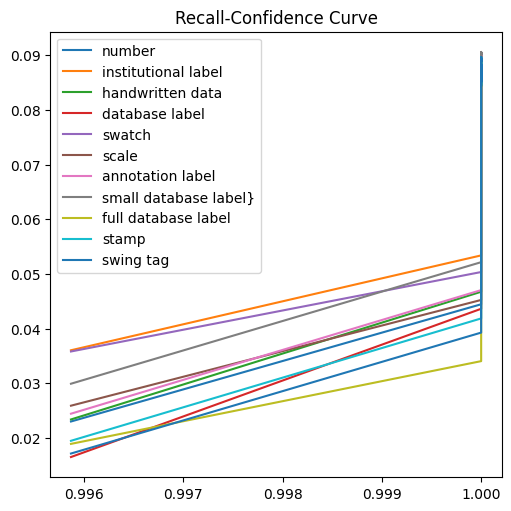

In [45]:
graphMetricHistory(Recall_accuracy,'Recall-Confidence Curve',categorias)

number
institutional label
handwritten data
database label
swatch
scale
annotation label
small database label}
full database label
stamp
swing tag


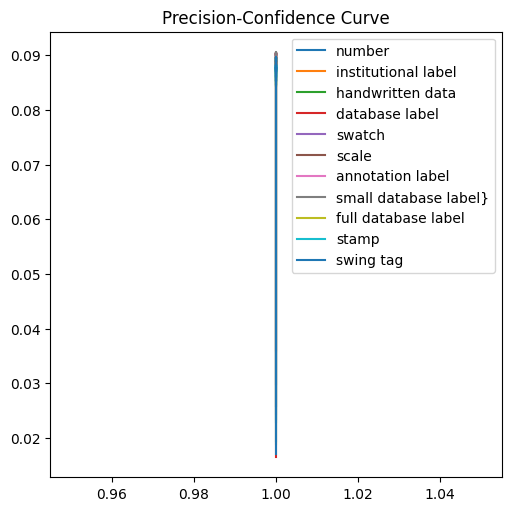

In [46]:
graphMetricHistory(Presicion_accuracy,'Precision-Confidence Curve',categorias)

number
institutional label
handwritten data
database label
swatch
scale
annotation label
small database label}
full database label
stamp
swing tag


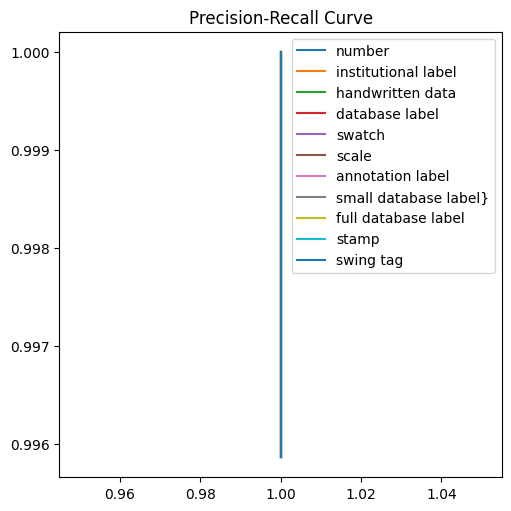

In [47]:
graphMetricHistory(Presicion_Recall,'Precision-Recall Curve',categorias)

number
institutional label
handwritten data
database label
swatch
scale
annotation label
small database label}
full database label
stamp
swing tag


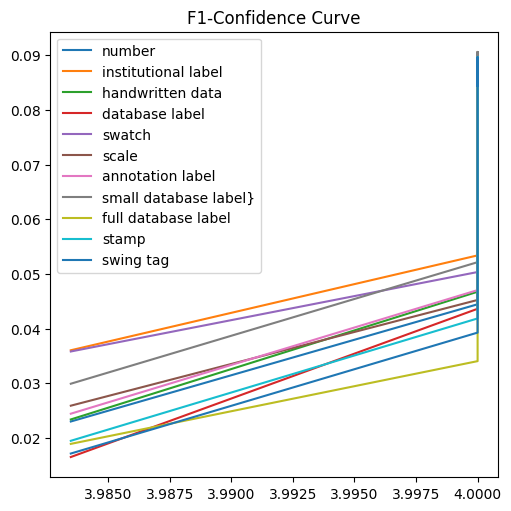

In [48]:
graphMetricHistory(F1score_accuracy,'F1-Confidence Curve',categorias)

In [49]:
metrics_dict['class_head5_precision']

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
target_classes

In [38]:
outpuTclassesUN = outputsUN[6:]
print(outpuTclassesUN[5][0][-1])
print(target_classes[1])

[4.5213672e-10 3.8373807e-10 1.0748455e-09 3.6777128e-09 3.6726638e-10
 1.0000000e+00]
[[[0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]]

 ...

 [[0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]]]


In [39]:
#not required to calculate confusion matrix on tensorflow because method history saves matrics into a dictionary

from tqdm import tqdm 
totalCMperImage = []

for category in tqdm(range(len(target_classes)), total= len(target_classes)):
   for vecInd in range(len(target_classes[category])):   
      targetSinglePrediction = target_classes[category][0][0]
      outputSinglePrediction = outpuTclassesUN[category][0][0]

      cm_per_individual_prediction = tf.math.confusion_matrix(
         outputSinglePrediction,
         targetSinglePrediction,
         num_classes=None,
         weights=None,
         dtype=tf.dtypes.int32,
         name=None
      )

      totalCMperImage.append(cm_per_individual_prediction.numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


In [40]:
totalCMperImage

[array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0],
        [0, 1]], dtype=int32),
 array([[5, 0

In [ ]:

for cm in totalCMperImage: #[0][0]#.argsort()
    isEqual = (totalCMperImage[0] == cm).all() 
    assert isEqual == 1
    #print(isEqual)


In [ ]:
len(target_classes)

In [ ]:
print(len(outputsUN[6:]))
print('---------------------------------')
print(len(outputsMElu))

In [ ]:
evaluateModelMeluTensorflow.evaluate()

In [ ]:
outputFilePath50UN = get_project_models('pytorch/CNN/50_10_0.001_UN_model_CNN_pytorch_results.json')
outputFilePath5UN = get_project_models('pytorch/CNN/5_10_0.001_UN_model_CNN_pytorch_results.json')
outputFilePath5Melu = get_project_models('pytorch/CNN/5_10_0.001_MELU_model_CNN_pytorch_results.json')

In [ ]:
from pickle import loads
import json
from typing import Union
cnf_melu = json.load(open(COCO_ANNOTATION_FILEMelu))
cngf_un = json.load(open(COCO_ANNOTATION_FILEUn))
num_clases_melu = len(cnf_melu['categories'])
num_clases_un = len(cngf_un['categories'])
print(num_clases_melu,num_clases_un)

def load_model_history(outputFilePath:str)->dict:
    with open(outputFilePath,'rb') as file:
        data = file.read()
        data_decoded = loads(data)
        return data_decoded

def get_epochs_by_loss_type(data:dict,loss_type:str)-> Union[list, None]:
    match loss_type:
        case 'bbox':
            return data['train_loss_history']['loss_bbox_per_class'] 
        case 'labels':
            return data['train_loss_history']['loss_class_per_class']
        case _ :
            print('loss type not found choose between bbox or labels')
            return None

def get_loss_values_per_class(loss_history:dict,num_clases:int)->list:
    loss_values = dict(zip([i for i in range(num_clases)],[[] for i in range(num_clases)])) #[]
    for epoch in loss_history:
        for i,ctg in enumerate(epoch):
            loss_values[i].append(ctg.item())
    return loss_values


In [ ]:
bbox_loss_history50un = get_epochs_by_loss_type(load_model_history(outputFilePath50UN),'bbox') 
label_loss_history50un = get_epochs_by_loss_type(load_model_history(outputFilePath50UN),'labels')

bbox_loss_history5un = get_epochs_by_loss_type(load_model_history(outputFilePath5UN),'bbox') 
label_loss_history5un = get_epochs_by_loss_type(load_model_history(outputFilePath5UN),'labels')

bbox_loss_history5Melu = get_epochs_by_loss_type(load_model_history(outputFilePath5Melu),'bbox') 
label_loss_history5Melu = get_epochs_by_loss_type(load_model_history(outputFilePath5Melu),'labels')

In [ ]:
bbox_loss_per_class50UN = get_loss_values_per_class(bbox_loss_history50un,num_clases_un)
labels_loss_per_class50UN = get_loss_values_per_class(label_loss_history50un,num_clases_un)

bbox_loss_per_class5UN = get_loss_values_per_class(bbox_loss_history5un,num_clases_un)
labels_loss_per_class5UN = get_loss_values_per_class(label_loss_history5un,num_clases_un)

bbox_loss_per_class5Melu = get_loss_values_per_class(bbox_loss_history5Melu,num_clases_melu)
labels_loss_per_class5Melu = get_loss_values_per_class(label_loss_history5Melu,num_clases_melu)

In [ ]:
import pandas as pd
df_bbox_loss_per_class50UN = pd.DataFrame(bbox_loss_per_class50UN)
df_labels_loss_per_class50UN = pd.DataFrame(labels_loss_per_class50UN)

df_bbox_loss_per_class5UN = pd.DataFrame(bbox_loss_per_class5UN)
df_labels_loss_per_class5UN = pd.DataFrame(labels_loss_per_class5UN)

df_bbox_loss_per_class5MELU = pd.DataFrame(bbox_loss_per_class5Melu)
df_labels_loss_per_class5MELU = pd.DataFrame(labels_loss_per_class5Melu)

In [ ]:
import seaborn as sns
df_bbox_loss_per_class50UN.plot(kind='line',figsize=(15,10))

In [ ]:
df_labels_loss_per_class50UN.plot(kind='line',figsize=(15,10))

In [ ]:
df_labels_loss_per_class5UN.plot(kind='line',figsize=(15,10))

In [ ]:
df_bbox_loss_per_class5UN.plot(kind='line',figsize=(15,10))

In [ ]:
df_bbox_loss_per_class5MELU.plot(kind='line',figsize=(15,10))

In [ ]:
df_labels_loss_per_class5MELU.plot(kind='line',figsize=(15,10))

In [ ]:
!python pytorchLocal/naive_model_torch.py --epochs 50 

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
{'train_loss_history': {'average_loss': [4380.3649894026785, 4375.904133711337, 4379.215625166339, 4372.668720603321, 4375.11512504476, 4378.137124466505, 4369.766317122416, 4373.145930465363, 4371.499491531216, 4371.230194592705, 4367.8263472116705, 4372.540797645, 4370.913987344911, 4371.002862168894, 4374.001628612284, 4376.0886001374265, 4370.035842777369, 4374.2901314563815, 4372.42737583835, 4368.3673155055985, 4371.291342859631, 4373.57856103561, 4375.297025839439, 4370.9130210652, 4376.742542861083, 4375.481325321428, 4370.586905972365, 4371.271035788339, 4375.431016096799, 4372.933265910498, 4371.756114176457, 4376.653057345298, 4374.604250541964, 4370.049034234428, 4375.653611254936, 4368.308149473038, 4370.654296421348, 4375.160164340135, 4378.265956317504, 4378.2198634143215, 4369.158970629331, 4373.735988641753, 4374.000485710553, 4374.182400039195, 4367.121199299802, 4373.7123409494525, 4374.3494531673405, 4371.381613799019, 4376.661265430232, 4369.38490618165], 'loss_bbox_per_class': [[0.8104857206344604, 0.8176897764205933, 0.8229198455810547, 0.8096415996551514, 0.8206740021705627, 0.825037956237793, 0.8015214204788208, 0.8146259188652039, 0.814335286617279, 0.8193675875663757, 0.8276734352111816], [0.8353760242462158, 0.8430627584457397, 0.8373390436172485, 0.8351219892501831, 0.829986572265625, 0.841965913772583, 0.8323310017585754, 0.8378605246543884, 0.8371990919113159, 0.8350871801376343, 0.8411180973052979], [0.8482943177223206, 0.8338451385498047, 0.8447428941726685, 0.8401917219161987, 0.8438965082168579, 0.8353345394134521, 0.8363432884216309, 0.8390350341796875, 0.8327634334564209, 0.8329669237136841, 0.8374373912811279], [0.8087658286094666, 0.8011155128479004, 0.8030844926834106, 0.8091509342193604, 0.8075470328330994, 0.7963714599609375, 0.7963510751724243, 0.7984287738800049, 0.8036046028137207, 0.8017353415489197, 0.8106984496116638], [0.8382164239883423, 0.8410639762878418, 0.8466254472732544, 0.8388831615447998, 0.8385398387908936, 0.8414523005485535, 0.8371862173080444, 0.8364005088806152, 0.830680787563324, 0.8319884538650513, 0.8470717072486877], [0.8513493537902832, 0.8476675748825073, 0.8505289554595947, 0.8481378555297852, 0.8569766283035278, 0.8498672246932983, 0.8538275361061096, 0.8531808853149414, 0.8518306016921997, 0.8493341207504272, 0.858860969543457], [0.8581665754318237, 0.847824215888977, 0.8571958541870117, 0.8462755680084229, 0.8587659597396851, 0.8487277626991272, 0.8484922051429749, 0.8550859093666077, 0.8483682870864868, 0.846773624420166, 0.8556438088417053], [0.8158589601516724, 0.8045116662979126, 0.8167284727096558, 0.8062372207641602, 0.8147243857383728, 0.8046833276748657, 0.8046393990516663, 0.8091990351676941, 0.8039305806159973, 0.8039067387580872, 0.808976411819458], [0.8398988246917725, 0.8217719793319702, 0.8334364295005798, 0.8329780697822571, 0.8372834920883179, 0.8351097702980042, 0.8307715654373169, 0.8411937952041626, 0.8373157978057861, 0.8269051909446716, 0.8345478177070618], [0.8197764158248901, 0.8124594688415527, 0.8175638914108276, 0.8095071911811829, 0.8204796314239502, 0.8083755970001221, 0.7980561852455139, 0.817500114440918, 0.8124488592147827, 0.8114912509918213, 0.8202101588249207], [0.851542592048645, 0.8492625951766968, 0.8546873331069946, 0.8455250263214111, 0.8490171432495117, 0.84209144115448, 0.8393737077713013, 0.8500970005989075, 0.8441269993782043, 0.8523097038269043, 0.8460168242454529], [0.8495305776596069, 0.8441809415817261, 0.8554499745368958, 0.8458248972892761, 0.8481518030166626, 0.845376193523407, 0.8471620678901672, 0.8519848585128784, 0.8475204706192017, 0.8454398512840271, 0.8493969440460205], [0.8249258399009705, 0.8192116022109985, 0.8220428824424744, 0.8160701394081116, 0.8232583999633789, 0.818079948425293, 0.8197913765907288, 0.8203809261322021, 0.8134176731109619, 0.8187524080276489, 0.8189198970794678], [0.8475337028503418, 0.8407350182533264, 0.8484679460525513, 0.8328876495361328, 0.8432455062866211, 0.8407791256904602, 0.8410337567329407, 0.850574254989624, 0.8368074893951416, 0.8420518636703491, 0.836711049079895], [0.8410803079605103, 0.8460208773612976, 0.8441693782806396, 0.8449281454086304, 0.8529511094093323, 0.8461321592330933, 0.8473318219184875, 0.8478687405586243, 0.8403993248939514, 0.8390956521034241, 0.8500120043754578], [0.8520063161849976, 0.8521465063095093, 0.8589829802513123, 0.8505488634109497, 0.8563200235366821, 0.8635969161987305, 0.8491350412368774, 0.8553021550178528, 0.856214702129364, 0.8575589656829834, 0.856757402420044], [0.8027572631835938, 0.804785966873169, 0.8080282211303711, 0.7987223863601685, 0.8055517673492432, 0.8035842776298523, 0.80265212059021, 0.8062953948974609, 0.790989875793457, 0.7994164228439331, 0.7993230819702148], [0.8404339551925659, 0.8356824517250061, 0.8387669920921326, 0.8308569192886353, 0.8335821628570557, 0.8317012190818787, 0.8391827940940857, 0.833744466304779, 0.8316875696182251, 0.8358703255653381, 0.8374306559562683], [0.829123854637146, 0.8214513659477234, 0.8343546390533447, 0.8285090923309326, 0.840582013130188, 0.8406669497489929, 0.8293924331665039, 0.8257449269294739, 0.8285908699035645, 0.830524206161499, 0.8282831907272339], [0.8505744934082031, 0.8525829315185547, 0.8629812002182007, 0.8459197282791138, 0.8545175790786743, 0.858917236328125, 0.8476826548576355, 0.8570209741592407, 0.8526861071586609, 0.8571265935897827, 0.8632482886314392], [0.8180005550384521, 0.8187676668167114, 0.819932222366333, 0.820026695728302, 0.8171312808990479, 0.8324354887008667, 0.8175637125968933, 0.8181445002555847, 0.8158829212188721, 0.822756826877594, 0.8140448927879333], [0.8363139629364014, 0.8443522453308105, 0.8438735604286194, 0.8388122916221619, 0.8427180647850037, 0.8463072776794434, 0.8348992466926575, 0.8464717864990234, 0.8366782665252686, 0.8398382067680359, 0.839083731174469], [0.8343680500984192, 0.8353472948074341, 0.8431056141853333, 0.8297823667526245, 0.8504998683929443, 0.842188835144043, 0.8310980200767517, 0.8403815031051636, 0.829751193523407, 0.841740071773529, 0.8397467732429504], [0.831915020942688, 0.8276395797729492, 0.839881956577301, 0.8244684934616089, 0.8331854939460754, 0.8411264419555664, 0.825708270072937, 0.8311340808868408, 0.8330665826797485, 0.8246527314186096, 0.815506100654602], [0.8950139880180359, 0.8913998603820801, 0.8954879641532898, 0.8953858613967896, 0.8958063125610352, 0.8893579244613647, 0.8907605409622192, 0.8885102868080139, 0.884232759475708, 0.8859226703643799, 0.8788555860519409], [0.8442966938018799, 0.8408275842666626, 0.8433288931846619, 0.8265945911407471, 0.8440992832183838, 0.8401262760162354, 0.8338800668716431, 0.8331592679023743, 0.8387783169746399, 0.8428949117660522, 0.8299200534820557], [0.8370748162269592, 0.843636691570282, 0.8491138219833374, 0.8422881364822388, 0.8432629704475403, 0.844947099685669, 0.8417657613754272, 0.8411775231361389, 0.8355794548988342, 0.8393115997314453, 0.8324673771858215], [0.8246623873710632, 0.831744909286499, 0.8396921753883362, 0.8181716203689575, 0.832303524017334, 0.8351352214813232, 0.8277696967124939, 0.8334881067276001, 0.8298885822296143, 0.8386390805244446, 0.8276903629302979], [0.8072746396064758, 0.8048509359359741, 0.8119155764579773, 0.8145132660865784, 0.812798798084259, 0.8114500045776367, 0.8023544549942017, 0.810194194316864, 0.807717502117157, 0.8101968169212341, 0.8003864884376526], [0.8354254961013794, 0.8360644578933716, 0.837030291557312, 0.8303164839744568, 0.8411164283752441, 0.8403168320655823, 0.8377931118011475, 0.8338482975959778, 0.8340975046157837, 0.8428303003311157, 0.8366202116012573], [0.8285398483276367, 0.8275608420372009, 0.8259576559066772, 0.814696192741394, 0.8294295072555542, 0.820123553276062, 0.8224793672561646, 0.8181549310684204, 0.8294835090637207, 0.826555609703064, 0.8221426010131836], [0.8523931503295898, 0.8408055305480957, 0.8395171165466309, 0.8390681147575378, 0.8401707410812378, 0.8397706151008606, 0.840734601020813, 0.8402183651924133, 0.8436065912246704, 0.8310831785202026, 0.8359980583190918], [0.7984018921852112, 0.7990107536315918, 0.8026929497718811, 0.8000755310058594, 0.8092653751373291, 0.8009440898895264, 0.7887899875640869, 0.8003305196762085, 0.7979097962379456, 0.7892823815345764, 0.7922052145004272], [0.8182491660118103, 0.8260821104049683, 0.8206574320793152, 0.8207771182060242, 0.8167966604232788, 0.8292116522789001, 0.8188767433166504, 0.8200011849403381, 0.81209796667099, 0.8219290971755981, 0.8239967823028564], [0.8142717480659485, 0.8115950226783752, 0.817908525466919, 0.808277428150177, 0.812272846698761, 0.8078356981277466, 0.8061760663986206, 0.8126484155654907, 0.8058738708496094, 0.8023288249969482, 0.8037792444229126], [0.7602779865264893, 0.7648134827613831, 0.7655616402626038, 0.76156085729599, 0.7740099430084229, 0.7835996150970459, 0.7491130828857422, 0.7571296691894531, 0.7730002999305725, 0.7760459184646606, 0.7548045516014099], [0.8189441561698914, 0.8288527131080627, 0.8377106189727783, 0.8103446364402771, 0.8295304775238037, 0.8323719501495361, 0.8205074667930603, 0.819267988204956, 0.8417900204658508, 0.8308718800544739, 0.8171238303184509], [0.8292331695556641, 0.8303640484809875, 0.8354219794273376, 0.8286570906639099, 0.834850549697876, 0.8365678191184998, 0.824640154838562, 0.8294284343719482, 0.8276974558830261, 0.8294292092323303, 0.821828305721283], [0.8139339685440063, 0.8165262937545776, 0.813606858253479, 0.8123147487640381, 0.8171061873435974, 0.8144288659095764, 0.8097512125968933, 0.8119232058525085, 0.811072826385498, 0.8045891523361206, 0.806920051574707], [0.8224068284034729, 0.8296788930892944, 0.832382082939148, 0.8171144723892212, 0.8303331136703491, 0.829369843006134, 0.8258737325668335, 0.83567214012146, 0.8347808718681335, 0.8233938217163086, 0.8378502130508423], [0.8400830030441284, 0.845485508441925, 0.842668890953064, 0.8395611643791199, 0.8520972728729248, 0.8464238047599792, 0.8333205580711365, 0.8407686948776245, 0.8421752452850342, 0.8431591987609863, 0.8413742184638977], [0.8395295739173889, 0.832086980342865, 0.8344916105270386, 0.83897864818573, 0.8377870321273804, 0.8396557569503784, 0.8272542357444763, 0.8260676860809326, 0.8297354578971863, 0.8345685005187988, 0.8296579718589783], [0.8121590614318848, 0.8151767253875732, 0.8216387033462524, 0.8119143843650818, 0.8227814435958862, 0.8114234209060669, 0.8169676661491394, 0.8071831464767456, 0.8113368153572083, 0.82179856300354, 0.8071764707565308], [0.8364903926849365, 0.8315072059631348, 0.8386073708534241, 0.8305654525756836, 0.8381679654121399, 0.8438040018081665, 0.8277571797370911, 0.8276044726371765, 0.8326852321624756, 0.8386331796646118, 0.8333745002746582], [0.817835807800293, 0.8239182233810425, 0.8335962891578674, 0.8275978565216064, 0.824729323387146, 0.8367201089859009, 0.8187075257301331, 0.8108978271484375, 0.826566219329834, 0.8247970342636108, 0.8161395192146301], [0.8175446391105652, 0.80992192029953, 0.8227940797805786, 0.814923882484436, 0.8179996013641357, 0.8117584586143494, 0.8078319430351257, 0.806694507598877, 0.8141087889671326, 0.8136643767356873, 0.8093714714050293], [0.8483161330223083, 0.8478689193725586, 0.8554049730300903, 0.8451380133628845, 0.8488035798072815, 0.846015453338623, 0.8466733694076538, 0.8481132984161377, 0.8500833511352539, 0.8542188405990601, 0.8561956882476807], [0.8426157832145691, 0.8561996817588806, 0.8525025844573975, 0.8522855043411255, 0.8590424656867981, 0.8598954677581787, 0.852103590965271, 0.849150538444519, 0.8531285524368286, 0.8476623296737671, 0.8556686639785767], [0.8731178045272827, 0.8741878867149353, 0.8813182711601257, 0.8750730752944946, 0.8815889954566956, 0.8734418153762817, 0.8766710758209229, 0.8765878081321716, 0.8688420057296753, 0.875951886177063, 0.8683915138244629], [0.8408553600311279, 0.8365187644958496, 0.8385416269302368, 0.8443046808242798, 0.839846134185791, 0.8490718603134155, 0.8398480415344238, 0.8388376832008362, 0.8447892665863037, 0.8360679745674133, 0.8449455499649048]], 'loss_class_per_class': [[400.31634521484375, 400.6247253417969, 401.0262451171875, 401.20074462890625, 400.1377258300781, 400.1221618652344, 400.4742126464844, 400.5751953125, 400.4871826171875, 401.07275390625, 400.3517150878906], [432.2643127441406, 432.4538269042969, 431.853515625, 433.93084716796875, 431.8068542480469, 432.208740234375, 431.7162780761719, 431.5884704589844, 431.7162780761719, 431.6368713378906, 430.7168273925781], [342.1110534667969, 342.3186340332031, 342.72955322265625, 341.6351623535156, 341.86553955078125, 342.4112548828125, 342.3486328125, 343.09429931640625, 342.19049072265625, 341.7667236328125, 342.2174072265625], [420.24554443359375, 421.50567626953125, 420.07574462890625, 420.7491455078125, 420.9074401855469, 419.7897033691406, 419.6653137207031, 420.0827941894531, 419.5451965332031, 419.40228271484375, 419.7053527832031], [323.6232604980469, 324.77972412109375, 325.64007568359375, 325.9510803222656, 325.227783203125, 325.4776916503906, 323.699462890625, 324.67889404296875, 325.6548767089844, 325.6737060546875, 325.2747802734375], [306.5662536621094, 306.398681640625, 306.079833984375, 306.8674011230469, 306.2529296875, 306.0677795410156, 306.6631774902344, 306.36212158203125, 305.8446350097656, 306.43548583984375, 305.882080078125], [300.2950439453125, 300.414794921875, 300.1826171875, 300.6311340332031, 299.8495178222656, 299.3133239746094, 300.47845458984375, 300.49786376953125, 299.90264892578125, 299.41943359375, 299.8995056152344], [405.4970397949219, 406.9920654296875, 406.10205078125, 406.0452880859375, 406.59991455078125, 405.46319580078125, 405.8417053222656, 406.0690002441406, 406.6377258300781, 406.5219421386719, 405.7386779785156], [339.1918029785156, 338.20281982421875, 338.6712951660156, 339.2707824707031, 338.1162109375, 339.25579833984375, 338.38885498046875, 337.99517822265625, 338.833251953125, 338.67755126953125, 338.2656555175781], [403.5252380371094, 403.298583984375, 403.1716003417969, 403.3490295410156, 402.98956298828125, 403.5670471191406, 403.12811279296875, 403.0419006347656, 404.02593994140625, 402.94140625, 403.1153259277344], [327.3114013671875, 327.24517822265625, 327.794921875, 327.60736083984375, 327.517822265625, 327.7666320800781, 327.30865478515625, 327.56695556640625, 327.3344421386719, 327.6517333984375, 327.73089599609375], [328.1443176269531, 328.134033203125, 328.06500244140625, 327.42578125, 328.1240234375, 328.61260986328125, 328.3091735839844, 328.2366943359375, 329.0064392089844, 328.046142578125, 328.33447265625], [387.9501037597656, 387.88201904296875, 387.895751953125, 389.09539794921875, 388.0424499511719, 388.25335693359375, 387.9866027832031, 387.9458923339844, 387.9276428222656, 388.1448974609375, 388.1126708984375], [335.6019592285156, 335.3193664550781, 335.5296630859375, 334.3454284667969, 335.3804626464844, 335.2923889160156, 335.8649597167969, 335.3218078613281, 335.341552734375, 335.3240966796875, 335.3182067871094], [325.6493835449219, 326.2183837890625, 325.7282409667969, 325.0439147949219, 325.64923095703125, 325.7848815917969, 325.8292236328125, 325.8354187011719, 325.4003601074219, 325.8357849121094, 325.6889343261719], [286.672119140625, 286.7764587402344, 286.8660888671875, 286.88983154296875, 286.3782043457031, 286.654296875, 286.58941650390625, 286.43402099609375, 286.7763977050781, 286.6326599121094, 286.31524658203125], [412.8141784667969, 412.6037292480469, 412.5126953125, 414.31439208984375, 412.52447509765625, 412.3558349609375, 412.2483215332031, 412.4378662109375, 412.88482666015625, 412.4956970214844, 412.3826599121094], [339.364501953125, 339.4407653808594, 339.33905029296875, 340.4500427246094, 339.1542053222656, 339.4217224121094, 339.752685546875, 339.5514831542969, 339.3541259765625, 339.4630432128906, 339.73321533203125], [358.48663330078125, 358.48663330078125, 358.42779541015625, 357.6452941894531, 358.4548645019531, 358.2696228027344, 358.48663330078125, 358.3948059082031, 358.9540710449219, 358.3127136230469, 358.21966552734375], [292.5924072265625, 292.54248046875, 292.5843811035156, 294.405029296875, 292.50457763671875, 292.5997314453125, 292.5315856933594, 292.6673583984375, 292.5032043457031, 292.7228698730469, 292.4739685058594], [379.21014404296875, 379.1656188964844, 379.2200927734375, 379.2675476074219, 379.12274169921875, 379.2064514160156, 379.3503112792969, 379.1888732910156, 379.1983947753906, 379.07354736328125, 379.1572570800781], [319.2860107421875, 319.15179443359375, 319.2995910644531, 319.35394287109375, 319.3476257324219, 319.4900817871094, 319.14837646484375, 319.528076171875, 319.2687072753906, 319.3787841796875, 319.28961181640625], [326.23980712890625, 325.9423522949219, 325.9779052734375, 325.9671630859375, 326.0283508300781, 326.0469665527344, 326.0008544921875, 326.00103759765625, 326.3808288574219, 326.0033264160156, 325.8796081542969], [362.6781311035156, 362.54669189453125, 362.3238830566406, 362.30792236328125, 362.41558837890625, 362.4815368652344, 362.29376220703125, 362.180908203125, 362.29498291015625, 362.2146301269531, 362.35089111328125], [463.6192932128906, 463.6248779296875, 463.588134765625, 463.57574462890625, 463.5928955078125, 463.58538818359375, 463.6123962402344, 463.7621765136719, 463.9630432128906, 463.63031005859375, 463.4833068847656], [337.7718200683594, 337.89892578125, 337.6488952636719, 337.6590576171875, 337.6808776855469, 337.701171875, 337.66259765625, 337.5974426269531, 337.70526123046875, 337.6608581542969, 337.9134521484375], [324.7081604003906, 324.7490234375, 324.8575134277344, 325.01690673828125, 324.8862609863281, 324.8270568847656, 324.8583984375, 324.6762390136719, 324.8439636230469, 324.9217834472656, 325.01885986328125], [358.5135498046875, 358.63580322265625, 358.56976318359375, 358.4934387207031, 358.425048828125, 358.458251953125, 358.486572265625, 358.4720458984375, 358.7264709472656, 358.49566650390625, 358.44110107421875], [405.9556579589844, 406.0280456542969, 405.9302673339844, 405.9427795410156, 405.8958435058594, 405.93743896484375, 405.8793029785156, 405.8464660644531, 405.8440856933594, 405.8645324707031, 405.87066650390625], [564.9044799804688, 564.908447265625, 565.0196533203125, 564.8903198242188, 565.0377197265625, 565.0806274414062, 565.0735473632812, 565.0377807617188, 564.9158935546875, 565.0368041992188, 565.006103515625], [358.8656311035156, 358.8141784667969, 358.8801574707031, 358.88531494140625, 358.9221496582031, 359.0246887207031, 358.8587646484375, 358.8844909667969, 359.1251220703125, 358.9252624511719, 358.91473388671875], [331.7243957519531, 331.76104736328125, 331.5594482421875, 331.6163635253906, 331.6883239746094, 331.7227783203125, 331.6319885253906, 331.7158508300781, 331.6869812011719, 331.6981201171875, 331.702880859375], [427.5985107421875, 427.578125, 427.5513000488281, 427.60650634765625, 427.54937744140625, 427.51812744140625, 427.69793701171875, 427.7482604980469, 427.61883544921875, 427.53173828125, 427.5723571777344], [388.0020751953125, 388.0804138183594, 388.09307861328125, 388.1541748046875, 388.1396179199219, 388.207275390625, 388.0601501464844, 388.2804870605469, 388.0313415527344, 388.1189270019531, 388.2029724121094], [404.8681640625, 405.1084899902344, 404.8268737792969, 404.9685363769531, 404.9539489746094, 404.9624938964844, 404.9993591308594, 404.7662353515625, 405.0172424316406, 405.3266906738281, 404.91656494140625], [515.3807983398438, 515.5010986328125, 515.293701171875, 515.3225708007812, 515.330810546875, 515.32177734375, 515.2882690429688, 515.3310546875, 515.2808227539062, 515.285888671875, 515.2958984375], [357.5610656738281, 357.620361328125, 357.4577941894531, 357.5079345703125, 357.50433349609375, 357.5034484863281, 357.5162353515625, 357.5028381347656, 357.4053955078125, 357.5231628417969, 357.474365234375], [350.6177978515625, 350.6220703125, 350.5828857421875, 350.5954284667969, 350.59246826171875, 350.5933532714844, 350.429931640625, 350.6947021484375, 350.7234191894531, 350.57080078125, 350.5740966796875], [396.4621276855469, 396.3009948730469, 396.46673583984375, 396.4918212890625, 396.48419189453125, 396.48516845703125, 396.4126281738281, 396.46881103515625, 396.6293640136719, 396.494140625, 396.5415954589844], [352.1738586425781, 352.0078125, 352.08673095703125, 352.109130859375, 352.1075439453125, 352.07403564453125, 351.948486328125, 352.2018127441406, 352.13812255859375, 352.14056396484375, 352.114013671875], [330.7941589355469, 330.909423828125, 330.7356262207031, 330.7885437011719, 330.79180908203125, 330.78155517578125, 330.7791748046875, 330.83380126953125, 330.87762451171875, 330.7593994140625, 330.74884033203125], [325.0086364746094, 325.0675048828125, 325.01531982421875, 325.0595397949219, 325.070556640625, 325.0775146484375, 324.9825134277344, 325.0307922363281, 325.00311279296875, 325.0857238769531, 325.1174621582031], [378.4460144042969, 378.4053955078125, 378.3683776855469, 378.3564147949219, 378.3372802734375, 378.37445068359375, 378.3562927246094, 378.5091552734375, 378.4736328125, 378.40704345703125, 378.327392578125], [319.5754699707031, 319.4754638671875, 319.5465087890625, 319.5434265136719, 319.5728759765625, 319.6044921875, 319.53521728515625, 319.58673095703125, 319.45404052734375, 319.53863525390625, 319.55633544921875], [352.8209533691406, 352.8044738769531, 352.7906188964844, 352.783935546875, 352.79779052734375, 352.7750244140625, 352.7585144042969, 352.76141357421875, 352.92181396484375, 352.8052062988281, 352.7921142578125], [386.13787841796875, 386.13665771484375, 386.10888671875, 386.0736083984375, 386.0834045410156, 386.1050720214844, 386.1931457519531, 386.053466796875, 386.0406799316406, 386.0872802734375, 386.1069641113281], [286.5316467285156, 286.5547790527344, 286.4952087402344, 286.37451171875, 286.53369140625, 286.4721984863281, 286.7107238769531, 286.38336181640625, 286.51220703125, 286.5129089355469, 286.53424072265625], [297.3746337890625, 297.4213562011719, 297.3291320800781, 297.34149169921875, 297.3426513671875, 297.318359375, 297.37725830078125, 297.40460205078125, 297.36083984375, 297.3843688964844, 297.3966064453125], [241.64910888671875, 241.60704040527344, 241.63507080078125, 241.671630859375, 241.66012573242188, 241.64096069335938, 241.74612426757812, 241.6597137451172, 241.6875762939453, 241.6381378173828, 241.67234802246094], [311.9956359863281, 312.0651550292969, 312.03228759765625, 312.03765869140625, 312.0518798828125, 312.0389709472656, 311.92730712890625, 311.96343994140625, 312.17645263671875, 312.03228759765625, 312.0270690917969]]}, 'test_loss_history': [4369.31517382752, 4373.30345152391, 4371.515633921831, 4371.913123363827, 4373.632872533341, 4375.521786809964, 4379.166110816405, 4371.799678950164, 4374.206023612307, 4376.3172963161005, 4370.64271747191, 4370.740000592773, 4372.4034719836345, 4373.254471576557, 4374.580885097093, 4375.079716866435, 4379.213593635075, 4374.7400293997025, 4368.623161195416, 4371.035032402882, 4374.903063091563, 4368.246109022965, 4372.926596161012, 4368.712787721503, 4367.901775625919, 4371.250809920834, 4368.611272476966, 4366.996247991832, 4370.049532344815, 4371.795392388196, 4372.863097520759, 4378.10985125946, 4367.952187905263, 4380.538059172006, 4366.6213163421335, 4366.620025700923, 4371.536474488401, 4367.9881696514985, 4370.203565723352, 4371.283469570204, 4374.730759314392, 4367.285233522133, 4376.794880138975, 4371.015884489199, 4368.600490065616, 4373.069225473129, 4376.2606304377805, 4370.964669774286, 4367.791698220714, 4364.932061916906], 'test_accuracy_history': [44.78166615051099, 67.57510065035615, 72.22050170331372, 71.63208423660576, 69.83586249612883, 66.30535769588107, 72.40631774543202, 73.6760606999071, 73.42830597708269, 73.39733663672963, 74.38835552802725, 74.6051409104986, 73.36636729637658, 75.68906782285538, 76.68008671415299, 74.66707959120471, 74.97677299473521, 90.64725921337876, 91.35955404149891, 72.87085785072777, 22.6385877980799, 23.010219882316505, 20.935274078662125, 36.45091359554041, 25.983276556209354, 29.947352121399813, 17.99318674512233, 24.34190151749768, 19.727469804893154, 19.139052338185195, 21.028182099721278, 19.634561783834005, 20.161040569835862, 21.771446268194488, 29.04924125116135, 29.235057293279652, 29.85444410034066, 27.469804893155775, 29.916382781046764, 31.55775781975844, 29.885413440693714, 11.427686590275627, 13.192938990399504, 10.21988231650666, 13.47166305357696, 10.250851656859709, 12.016104056983586, 11.087023846392071, 10.777330442861567, 8.609476618148033]}
Model saved to d:\herbario\models\pytorch/CNN/50_10_0.001_MELU_model_CNN_pytorch.pth.pt

  0%|          | 0/50 [00:00<?, ?it/s]
  2%|▏         | 1/50 [15:51<12:57:09, 951.62s/it]
  4%|▍         | 2/50 [31:39<12:39:33, 949.44s/it]
  6%|▌         | 3/50 [47:43<12:28:59, 956.15s/it]
  8%|▊         | 4/50 [1:03:51<12:16:26, 960.58s/it]
 10%|█         | 5/50 [1:19:43<11:58:14, 957.66s/it]
 12%|█▏        | 6/50 [1:35:43<11:42:58, 958.59s/it]
 14%|█▍        | 7/50 [1:52:20<11:35:49, 970.91s/it]
 16%|█▌        | 8/50 [2:08:06<11:14:05, 962.98s/it]
 18%|█▊        | 9/50 [2:23:49<10:53:47, 956.76s/it]
 20%|██        | 10/50 [2:39:37<10:35:59, 954.00s/it]
 22%|██▏       | 11/50 [2:55:22<10:18:17, 951.22s/it]
 24%|██▍       | 12/50 [3:11:08<10:01:28, 949.69s/it]
 26%|██▌       | 13/50 [3:26:52<9:44:40, 948.11s/it] 
 28%|██▊       | 14/50 [3:42:40<9:28:45, 947.92s/it]
 30%|███       | 15/50 [3:58:25<9:12:28, 947.10s/it]
 32%|███▏      | 16/50 [4:14:09<8:56:14, 946.32s/it]
 34%|███▍      | 17/50 [4:29:55<8:40:18, 946.01s/it]
 36%|███▌      | 18/50 [4:45:40<8:24:21, 945.68s/it]
 38%|███▊      | 19/50 [5:01:25<8:08:33, 945.61s/it]
 40%|████      | 20/50 [5:17:10<7:52:46, 945.55s/it]
 42%|████▏     | 21/50 [5:32:50<7:36:12, 943.88s/it]
 44%|████▍     | 22/50 [5:48:28<7:19:38, 942.09s/it]
 46%|████▌     | 23/50 [6:04:11<7:04:02, 942.33s/it]
 48%|████▊     | 24/50 [6:19:55<6:48:35, 942.89s/it]
 50%|█████     | 25/50 [6:35:39<6:32:57, 943.09s/it]
 52%|█████▏    | 26/50 [6:51:23<6:17:20, 943.34s/it]
 54%|█████▍    | 27/50 [7:07:32<6:04:33, 951.03s/it]
 56%|█████▌    | 28/50 [7:23:58<5:52:37, 961.69s/it]
 58%|█████▊    | 29/50 [7:40:02<5:36:45, 962.18s/it]
 60%|██████    | 30/50 [7:55:46<5:18:56, 956.82s/it]
 62%|██████▏   | 31/50 [8:11:30<5:01:47, 953.03s/it]
 64%|██████▍   | 32/50 [8:27:14<4:45:03, 950.20s/it]
 66%|██████▌   | 33/50 [8:42:59<4:28:47, 948.66s/it]
 68%|██████▊   | 34/50 [8:58:43<4:12:34, 947.18s/it]
 70%|███████   | 35/50 [9:14:28<3:56:38, 946.60s/it]
 72%|███████▏  | 36/50 [9:30:12<3:40:40, 945.77s/it]
 74%|███████▍  | 37/50 [9:45:56<3:24:48, 945.24s/it]
 76%|███████▌  | 38/50 [10:01:42<3:09:08, 945.69s/it]
 78%|███████▊  | 39/50 [10:17:42<2:54:07, 949.80s/it]
 80%|████████  | 40/50 [10:33:26<2:38:01, 948.19s/it]
 82%|████████▏ | 41/50 [10:49:10<2:22:02, 946.98s/it]
 84%|████████▍ | 42/50 [11:04:55<2:06:10, 946.37s/it]
 86%|████████▌ | 43/50 [11:20:40<1:50:21, 945.96s/it]
 88%|████████▊ | 44/50 [11:36:24<1:34:30, 945.15s/it]
 90%|█████████ | 45/50 [11:52:08<1:18:44, 944.91s/it]
 92%|█████████▏| 46/50 [12:07:53<1:02:59, 944.99s/it]
 94%|█████████▍| 47/50 [12:23:37<47:14, 944.76s/it]  
 96%|█████████▌| 48/50 [12:39:23<31:29, 944.94s/it]
 98%|█████████▊| 49/50 [12:55:07<15:44, 944.84s/it]
100%|██████████| 50/50 [13:10:54<00:00, 945.34s/it]
100%|██████████| 50/50 [13:10:54<00:00, 949.09s/it]


In [ ]:
!python pytorchLocal/naive_model_torch.py --epochs 50 --trainSet MELU

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
{'train_loss_history': {'average_loss': [2031.1336496420922, 2027.0142611585898, 2033.500202934149, 2027.9761507450626, 2034.4993800439206, 2031.0224553606836, 2026.5174923039935, 2025.7637697791085, 2028.2658852514276, 2033.5360931551395, 2028.1103308043505, 2030.7876506360049, 2030.1829019149548, 2026.665217830445, 2031.1357601572415, 2030.0693055748334, 2034.4407113167235, 2029.0526804657757, 2022.1595316465737, 2029.0836723831098, 2031.840198807305, 2026.7085060080901, 2032.0959119457884, 2025.4824575046598, 2030.6153657400064, 2032.100095177665, 2028.9513013810677, 2033.4077644154504, 2034.4319894858422, 2024.6482890947216, 2030.465547668147, 2027.1063663076022, 2026.380898102891, 2028.297186682067, 2028.5937152998097, 2031.6675374762056, 2028.3418387011222, 2034.1495317952888, 2020.2437285602396, 2028.7391605280377, 2029.4356215423738, 2029.2182372427228, 2024.322497682523, 2028.9761795586135, 2020.8320820609931, 2031.5906619928815, 2029.9130685874047, 2029.4087307537873, 2029.5025117361001, 2027.3264358443053], 'loss_bbox_per_class': [[tensor(0.7543, grad_fn=<RsubBackward1>), tensor(0.7427, grad_fn=<RsubBackward1>), tensor(0.7335, grad_fn=<RsubBackward1>), tensor(0.7241, grad_fn=<RsubBackward1>), tensor(0.7498, grad_fn=<RsubBackward1>), tensor(0.7577, grad_fn=<RsubBackward1>)], [tensor(0.8318, grad_fn=<RsubBackward1>), tensor(0.8168, grad_fn=<RsubBackward1>), tensor(0.8379, grad_fn=<RsubBackward1>), tensor(0.8250, grad_fn=<RsubBackward1>), tensor(0.8478, grad_fn=<RsubBackward1>), tensor(0.8407, grad_fn=<RsubBackward1>)], [tensor(0.7857, grad_fn=<RsubBackward1>), tensor(0.7888, grad_fn=<RsubBackward1>), tensor(0.7707, grad_fn=<RsubBackward1>), tensor(0.7722, grad_fn=<RsubBackward1>), tensor(0.7939, grad_fn=<RsubBackward1>), tensor(0.8042, grad_fn=<RsubBackward1>)], [tensor(0.7688, grad_fn=<RsubBackward1>), tensor(0.7539, grad_fn=<RsubBackward1>), tensor(0.7641, grad_fn=<RsubBackward1>), tensor(0.7497, grad_fn=<RsubBackward1>), tensor(0.7700, grad_fn=<RsubBackward1>), tensor(0.7722, grad_fn=<RsubBackward1>)], [tensor(0.7482, grad_fn=<RsubBackward1>), tensor(0.7284, grad_fn=<RsubBackward1>), tensor(0.7362, grad_fn=<RsubBackward1>), tensor(0.7435, grad_fn=<RsubBackward1>), tensor(0.7586, grad_fn=<RsubBackward1>), tensor(0.7521, grad_fn=<RsubBackward1>)], [tensor(0.7484, grad_fn=<RsubBackward1>), tensor(0.7267, grad_fn=<RsubBackward1>), tensor(0.7603, grad_fn=<RsubBackward1>), tensor(0.7517, grad_fn=<RsubBackward1>), tensor(0.7648, grad_fn=<RsubBackward1>), tensor(0.7556, grad_fn=<RsubBackward1>)], [tensor(0.7503, grad_fn=<RsubBackward1>), tensor(0.7267, grad_fn=<RsubBackward1>), tensor(0.7347, grad_fn=<RsubBackward1>), tensor(0.7593, grad_fn=<RsubBackward1>), tensor(0.7542, grad_fn=<RsubBackward1>), tensor(0.7629, grad_fn=<RsubBackward1>)], [tensor(0.7892, grad_fn=<RsubBackward1>), tensor(0.7807, grad_fn=<RsubBackward1>), tensor(0.7937, grad_fn=<RsubBackward1>), tensor(0.7916, grad_fn=<RsubBackward1>), tensor(0.8002, grad_fn=<RsubBackward1>), tensor(0.8000, grad_fn=<RsubBackward1>)], [tensor(0.7754, grad_fn=<RsubBackward1>), tensor(0.7357, grad_fn=<RsubBackward1>), tensor(0.7537, grad_fn=<RsubBackward1>), tensor(0.7584, grad_fn=<RsubBackward1>), tensor(0.7833, grad_fn=<RsubBackward1>), tensor(0.7686, grad_fn=<RsubBackward1>)], [tensor(0.7231, grad_fn=<RsubBackward1>), tensor(0.7285, grad_fn=<RsubBackward1>), tensor(0.7268, grad_fn=<RsubBackward1>), tensor(0.7235, grad_fn=<RsubBackward1>), tensor(0.7264, grad_fn=<RsubBackward1>), tensor(0.7623, grad_fn=<RsubBackward1>)], [tensor(0.7830, grad_fn=<RsubBackward1>), tensor(0.7465, grad_fn=<RsubBackward1>), tensor(0.7474, grad_fn=<RsubBackward1>), tensor(0.7675, grad_fn=<RsubBackward1>), tensor(0.7902, grad_fn=<RsubBackward1>), tensor(0.7759, grad_fn=<RsubBackward1>)], [tensor(0.7006, grad_fn=<RsubBackward1>), tensor(0.7072, grad_fn=<RsubBackward1>), tensor(0.7096, grad_fn=<RsubBackward1>), tensor(0.7056, grad_fn=<RsubBackward1>), tensor(0.7192, grad_fn=<RsubBackward1>), tensor(0.7447, grad_fn=<RsubBackward1>)], [tensor(0.8182, grad_fn=<RsubBackward1>), tensor(0.8136, grad_fn=<RsubBackward1>), tensor(0.8203, grad_fn=<RsubBackward1>), tensor(0.7845, grad_fn=<RsubBackward1>), tensor(0.8084, grad_fn=<RsubBackward1>), tensor(0.8207, grad_fn=<RsubBackward1>)], [tensor(0.7488, grad_fn=<RsubBackward1>), tensor(0.7383, grad_fn=<RsubBackward1>), tensor(0.7550, grad_fn=<RsubBackward1>), tensor(0.7533, grad_fn=<RsubBackward1>), tensor(0.7716, grad_fn=<RsubBackward1>), tensor(0.7682, grad_fn=<RsubBackward1>)], [tensor(0.7602, grad_fn=<RsubBackward1>), tensor(0.7640, grad_fn=<RsubBackward1>), tensor(0.7612, grad_fn=<RsubBackward1>), tensor(0.7424, grad_fn=<RsubBackward1>), tensor(0.7634, grad_fn=<RsubBackward1>), tensor(0.7827, grad_fn=<RsubBackward1>)], [tensor(0.7741, grad_fn=<RsubBackward1>), tensor(0.7570, grad_fn=<RsubBackward1>), tensor(0.7721, grad_fn=<RsubBackward1>), tensor(0.7795, grad_fn=<RsubBackward1>), tensor(0.7835, grad_fn=<RsubBackward1>), tensor(0.7706, grad_fn=<RsubBackward1>)], [tensor(0.7382, grad_fn=<RsubBackward1>), tensor(0.7126, grad_fn=<RsubBackward1>), tensor(0.7254, grad_fn=<RsubBackward1>), tensor(0.7228, grad_fn=<RsubBackward1>), tensor(0.7465, grad_fn=<RsubBackward1>), tensor(0.7387, grad_fn=<RsubBackward1>)], [tensor(0.8087, grad_fn=<RsubBackward1>), tensor(0.8040, grad_fn=<RsubBackward1>), tensor(0.8015, grad_fn=<RsubBackward1>), tensor(0.8037, grad_fn=<RsubBackward1>), tensor(0.8173, grad_fn=<RsubBackward1>), tensor(0.8182, grad_fn=<RsubBackward1>)], [tensor(0.8580, grad_fn=<RsubBackward1>), tensor(0.8488, grad_fn=<RsubBackward1>), tensor(0.8499, grad_fn=<RsubBackward1>), tensor(0.8483, grad_fn=<RsubBackward1>), tensor(0.8551, grad_fn=<RsubBackward1>), tensor(0.8590, grad_fn=<RsubBackward1>)], [tensor(0.7072, grad_fn=<RsubBackward1>), tensor(0.7058, grad_fn=<RsubBackward1>), tensor(0.6964, grad_fn=<RsubBackward1>), tensor(0.6859, grad_fn=<RsubBackward1>), tensor(0.7156, grad_fn=<RsubBackward1>), tensor(0.7326, grad_fn=<RsubBackward1>)], [tensor(0.7668, grad_fn=<RsubBackward1>), tensor(0.7627, grad_fn=<RsubBackward1>), tensor(0.7765, grad_fn=<RsubBackward1>), tensor(0.7460, grad_fn=<RsubBackward1>), tensor(0.7795, grad_fn=<RsubBackward1>), tensor(0.7747, grad_fn=<RsubBackward1>)], [tensor(0.8055, grad_fn=<RsubBackward1>), tensor(0.7948, grad_fn=<RsubBackward1>), tensor(0.7927, grad_fn=<RsubBackward1>), tensor(0.8092, grad_fn=<RsubBackward1>), tensor(0.8089, grad_fn=<RsubBackward1>), tensor(0.8325, grad_fn=<RsubBackward1>)], [tensor(0.7968, grad_fn=<RsubBackward1>), tensor(0.8111, grad_fn=<RsubBackward1>), tensor(0.8091, grad_fn=<RsubBackward1>), tensor(0.8092, grad_fn=<RsubBackward1>), tensor(0.8136, grad_fn=<RsubBackward1>), tensor(0.8144, grad_fn=<RsubBackward1>)], [tensor(0.7976, grad_fn=<RsubBackward1>), tensor(0.7587, grad_fn=<RsubBackward1>), tensor(0.7915, grad_fn=<RsubBackward1>), tensor(0.7726, grad_fn=<RsubBackward1>), tensor(0.8012, grad_fn=<RsubBackward1>), tensor(0.7975, grad_fn=<RsubBackward1>)], [tensor(0.7158, grad_fn=<RsubBackward1>), tensor(0.7408, grad_fn=<RsubBackward1>), tensor(0.7265, grad_fn=<RsubBackward1>), tensor(0.7091, grad_fn=<RsubBackward1>), tensor(0.7394, grad_fn=<RsubBackward1>), tensor(0.7538, grad_fn=<RsubBackward1>)], [tensor(0.7925, grad_fn=<RsubBackward1>), tensor(0.8033, grad_fn=<RsubBackward1>), tensor(0.7817, grad_fn=<RsubBackward1>), tensor(0.7798, grad_fn=<RsubBackward1>), tensor(0.8148, grad_fn=<RsubBackward1>), tensor(0.8103, grad_fn=<RsubBackward1>)], [tensor(0.7693, grad_fn=<RsubBackward1>), tensor(0.7287, grad_fn=<RsubBackward1>), tensor(0.7594, grad_fn=<RsubBackward1>), tensor(0.7581, grad_fn=<RsubBackward1>), tensor(0.7785, grad_fn=<RsubBackward1>), tensor(0.7791, grad_fn=<RsubBackward1>)], [tensor(0.7244, grad_fn=<RsubBackward1>), tensor(0.7190, grad_fn=<RsubBackward1>), tensor(0.7209, grad_fn=<RsubBackward1>), tensor(0.7317, grad_fn=<RsubBackward1>), tensor(0.7415, grad_fn=<RsubBackward1>), tensor(0.7408, grad_fn=<RsubBackward1>)], [tensor(0.7296, grad_fn=<RsubBackward1>), tensor(0.7171, grad_fn=<RsubBackward1>), tensor(0.7241, grad_fn=<RsubBackward1>), tensor(0.7083, grad_fn=<RsubBackward1>), tensor(0.7224, grad_fn=<RsubBackward1>), tensor(0.7329, grad_fn=<RsubBackward1>)], [tensor(0.7548, grad_fn=<RsubBackward1>), tensor(0.7361, grad_fn=<RsubBackward1>), tensor(0.7528, grad_fn=<RsubBackward1>), tensor(0.7284, grad_fn=<RsubBackward1>), tensor(0.7672, grad_fn=<RsubBackward1>), tensor(0.7689, grad_fn=<RsubBackward1>)], [tensor(0.7751, grad_fn=<RsubBackward1>), tensor(0.7919, grad_fn=<RsubBackward1>), tensor(0.8110, grad_fn=<RsubBackward1>), tensor(0.7857, grad_fn=<RsubBackward1>), tensor(0.7955, grad_fn=<RsubBackward1>), tensor(0.8026, grad_fn=<RsubBackward1>)], [tensor(0.7699, grad_fn=<RsubBackward1>), tensor(0.7603, grad_fn=<RsubBackward1>), tensor(0.7665, grad_fn=<RsubBackward1>), tensor(0.7539, grad_fn=<RsubBackward1>), tensor(0.7734, grad_fn=<RsubBackward1>), tensor(0.7674, grad_fn=<RsubBackward1>)], [tensor(0.7626, grad_fn=<RsubBackward1>), tensor(0.7430, grad_fn=<RsubBackward1>), tensor(0.7415, grad_fn=<RsubBackward1>), tensor(0.7475, grad_fn=<RsubBackward1>), tensor(0.7648, grad_fn=<RsubBackward1>), tensor(0.7648, grad_fn=<RsubBackward1>)], [tensor(0.6847, grad_fn=<RsubBackward1>), tensor(0.6764, grad_fn=<RsubBackward1>), tensor(0.7111, grad_fn=<RsubBackward1>), tensor(0.6891, grad_fn=<RsubBackward1>), tensor(0.7171, grad_fn=<RsubBackward1>), tensor(0.7154, grad_fn=<RsubBackward1>)], [tensor(0.7989, grad_fn=<RsubBackward1>), tensor(0.8056, grad_fn=<RsubBackward1>), tensor(0.8148, grad_fn=<RsubBackward1>), tensor(0.8110, grad_fn=<RsubBackward1>), tensor(0.8206, grad_fn=<RsubBackward1>), tensor(0.8129, grad_fn=<RsubBackward1>)], [tensor(0.7257, grad_fn=<RsubBackward1>), tensor(0.7342, grad_fn=<RsubBackward1>), tensor(0.7352, grad_fn=<RsubBackward1>), tensor(0.7364, grad_fn=<RsubBackward1>), tensor(0.7495, grad_fn=<RsubBackward1>), tensor(0.7566, grad_fn=<RsubBackward1>)], [tensor(0.7711, grad_fn=<RsubBackward1>), tensor(0.7818, grad_fn=<RsubBackward1>), tensor(0.7932, grad_fn=<RsubBackward1>), tensor(0.7756, grad_fn=<RsubBackward1>), tensor(0.7678, grad_fn=<RsubBackward1>), tensor(0.7930, grad_fn=<RsubBackward1>)], [tensor(0.7369, grad_fn=<RsubBackward1>), tensor(0.7312, grad_fn=<RsubBackward1>), tensor(0.7492, grad_fn=<RsubBackward1>), tensor(0.7361, grad_fn=<RsubBackward1>), tensor(0.7573, grad_fn=<RsubBackward1>), tensor(0.7539, grad_fn=<RsubBackward1>)], [tensor(0.8751, grad_fn=<RsubBackward1>), tensor(0.8791, grad_fn=<RsubBackward1>), tensor(0.8735, grad_fn=<RsubBackward1>), tensor(0.8719, grad_fn=<RsubBackward1>), tensor(0.8866, grad_fn=<RsubBackward1>), tensor(0.8769, grad_fn=<RsubBackward1>)], [tensor(0.8033, grad_fn=<RsubBackward1>), tensor(0.7888, grad_fn=<RsubBackward1>), tensor(0.8012, grad_fn=<RsubBackward1>), tensor(0.7978, grad_fn=<RsubBackward1>), tensor(0.7947, grad_fn=<RsubBackward1>), tensor(0.8010, grad_fn=<RsubBackward1>)], [tensor(0.7303, grad_fn=<RsubBackward1>), tensor(0.7375, grad_fn=<RsubBackward1>), tensor(0.7232, grad_fn=<RsubBackward1>), tensor(0.7026, grad_fn=<RsubBackward1>), tensor(0.7351, grad_fn=<RsubBackward1>), tensor(0.7474, grad_fn=<RsubBackward1>)], [tensor(0.7590, grad_fn=<RsubBackward1>), tensor(0.7758, grad_fn=<RsubBackward1>), tensor(0.7814, grad_fn=<RsubBackward1>), tensor(0.7603, grad_fn=<RsubBackward1>), tensor(0.7788, grad_fn=<RsubBackward1>), tensor(0.7739, grad_fn=<RsubBackward1>)], [tensor(0.7567, grad_fn=<RsubBackward1>), tensor(0.7458, grad_fn=<RsubBackward1>), tensor(0.7990, grad_fn=<RsubBackward1>), tensor(0.7609, grad_fn=<RsubBackward1>), tensor(0.7693, grad_fn=<RsubBackward1>), tensor(0.7707, grad_fn=<RsubBackward1>)], [tensor(0.7514, grad_fn=<RsubBackward1>), tensor(0.7467, grad_fn=<RsubBackward1>), tensor(0.7600, grad_fn=<RsubBackward1>), tensor(0.7558, grad_fn=<RsubBackward1>), tensor(0.7820, grad_fn=<RsubBackward1>), tensor(0.7822, grad_fn=<RsubBackward1>)], [tensor(0.7840, grad_fn=<RsubBackward1>), tensor(0.7586, grad_fn=<RsubBackward1>), tensor(0.7741, grad_fn=<RsubBackward1>), tensor(0.7683, grad_fn=<RsubBackward1>), tensor(0.7927, grad_fn=<RsubBackward1>), tensor(0.7795, grad_fn=<RsubBackward1>)], [tensor(0.8143, grad_fn=<RsubBackward1>), tensor(0.8158, grad_fn=<RsubBackward1>), tensor(0.8361, grad_fn=<RsubBackward1>), tensor(0.8222, grad_fn=<RsubBackward1>), tensor(0.8405, grad_fn=<RsubBackward1>), tensor(0.8294, grad_fn=<RsubBackward1>)], [tensor(0.7803, grad_fn=<RsubBackward1>), tensor(0.7400, grad_fn=<RsubBackward1>), tensor(0.7580, grad_fn=<RsubBackward1>), tensor(0.7724, grad_fn=<RsubBackward1>), tensor(0.7734, grad_fn=<RsubBackward1>), tensor(0.7694, grad_fn=<RsubBackward1>)], [tensor(0.8147, grad_fn=<RsubBackward1>), tensor(0.7959, grad_fn=<RsubBackward1>), tensor(0.8082, grad_fn=<RsubBackward1>), tensor(0.8044, grad_fn=<RsubBackward1>), tensor(0.8232, grad_fn=<RsubBackward1>), tensor(0.8129, grad_fn=<RsubBackward1>)], [tensor(0.7606, grad_fn=<RsubBackward1>), tensor(0.7515, grad_fn=<RsubBackward1>), tensor(0.7703, grad_fn=<RsubBackward1>), tensor(0.7356, grad_fn=<RsubBackward1>), tensor(0.7983, grad_fn=<RsubBackward1>), tensor(0.7807, grad_fn=<RsubBackward1>)], [tensor(0.7491, grad_fn=<RsubBackward1>), tensor(0.7482, grad_fn=<RsubBackward1>), tensor(0.7581, grad_fn=<RsubBackward1>), tensor(0.7585, grad_fn=<RsubBackward1>), tensor(0.7668, grad_fn=<RsubBackward1>), tensor(0.7788, grad_fn=<RsubBackward1>)]], 'loss_class_per_class': [[tensor(145.0170, grad_fn=<DivBackward1>), tensor(144.1494, grad_fn=<DivBackward1>), tensor(144.1585, grad_fn=<DivBackward1>), tensor(143.3072, grad_fn=<DivBackward1>), tensor(144.4230, grad_fn=<DivBackward1>), tensor(144.1800, grad_fn=<DivBackward1>)], [tensor(199.3644, grad_fn=<DivBackward1>), tensor(199.4769, grad_fn=<DivBackward1>), tensor(199.5483, grad_fn=<DivBackward1>), tensor(199.6184, grad_fn=<DivBackward1>), tensor(199.7465, grad_fn=<DivBackward1>), tensor(199.5622, grad_fn=<DivBackward1>)], [tensor(153.0957, grad_fn=<DivBackward1>), tensor(153.1180, grad_fn=<DivBackward1>), tensor(153.0996, grad_fn=<DivBackward1>), tensor(152.9282, grad_fn=<DivBackward1>), tensor(152.6362, grad_fn=<DivBackward1>), tensor(153.1176, grad_fn=<DivBackward1>)], [tensor(155.0909, grad_fn=<DivBackward1>), tensor(154.8162, grad_fn=<DivBackward1>), tensor(154.7857, grad_fn=<DivBackward1>), tensor(155.2670, grad_fn=<DivBackward1>), tensor(154.0421, grad_fn=<DivBackward1>), tensor(154.8020, grad_fn=<DivBackward1>)], [tensor(109.3418, grad_fn=<DivBackward1>), tensor(110.0010, grad_fn=<DivBackward1>), tensor(109.9596, grad_fn=<DivBackward1>), tensor(109.7715, grad_fn=<DivBackward1>), tensor(108.8909, grad_fn=<DivBackward1>), tensor(109.9748, grad_fn=<DivBackward1>)], [tensor(105.1034, grad_fn=<DivBackward1>), tensor(105.1270, grad_fn=<DivBackward1>), tensor(105.1722, grad_fn=<DivBackward1>), tensor(105.2574, grad_fn=<DivBackward1>), tensor(105.1837, grad_fn=<DivBackward1>), tensor(105.1805, grad_fn=<DivBackward1>)], [tensor(110.2773, grad_fn=<DivBackward1>), tensor(109.9526, grad_fn=<DivBackward1>), tensor(109.8950, grad_fn=<DivBackward1>), tensor(109.5862, grad_fn=<DivBackward1>), tensor(109.7486, grad_fn=<DivBackward1>), tensor(109.9084, grad_fn=<DivBackward1>)], [tensor(135.4998, grad_fn=<DivBackward1>), tensor(136.4875, grad_fn=<DivBackward1>), tensor(136.4244, grad_fn=<DivBackward1>), tensor(135.8664, grad_fn=<DivBackward1>), tensor(135.9122, grad_fn=<DivBackward1>), tensor(136.4376, grad_fn=<DivBackward1>)], [tensor(174.8681, grad_fn=<DivBackward1>), tensor(174.9901, grad_fn=<DivBackward1>), tensor(174.9235, grad_fn=<DivBackward1>), tensor(174.8736, grad_fn=<DivBackward1>), tensor(174.8101, grad_fn=<DivBackward1>), tensor(174.9355, grad_fn=<DivBackward1>)], [tensor(118.6460, grad_fn=<DivBackward1>), tensor(118.9951, grad_fn=<DivBackward1>), tensor(118.9254, grad_fn=<DivBackward1>), tensor(118.5192, grad_fn=<DivBackward1>), tensor(118.3342, grad_fn=<DivBackward1>), tensor(118.9370, grad_fn=<DivBackward1>)], [tensor(147.5615, grad_fn=<DivBackward1>), tensor(147.6958, grad_fn=<DivBackward1>), tensor(147.7276, grad_fn=<DivBackward1>), tensor(147.5039, grad_fn=<DivBackward1>), tensor(147.7650, grad_fn=<DivBackward1>), tensor(147.7322, grad_fn=<DivBackward1>)], [tensor(129.4853, grad_fn=<DivBackward1>), tensor(129.6808, grad_fn=<DivBackward1>), tensor(129.7129, grad_fn=<DivBackward1>), tensor(129.7976, grad_fn=<DivBackward1>), tensor(129.2943, grad_fn=<DivBackward1>), tensor(129.7165, grad_fn=<DivBackward1>)], [tensor(166.7900, grad_fn=<DivBackward1>), tensor(167.3621, grad_fn=<DivBackward1>), tensor(167.2895, grad_fn=<DivBackward1>), tensor(167.4394, grad_fn=<DivBackward1>), tensor(166.8534, grad_fn=<DivBackward1>), tensor(167.2995, grad_fn=<DivBackward1>)], [tensor(132.9999, grad_fn=<DivBackward1>), tensor(133.1089, grad_fn=<DivBackward1>), tensor(133.0383, grad_fn=<DivBackward1>), tensor(133.2164, grad_fn=<DivBackward1>), tensor(133.3175, grad_fn=<DivBackward1>), tensor(133.0476, grad_fn=<DivBackward1>)], [tensor(143.2857, grad_fn=<DivBackward1>), tensor(143.8327, grad_fn=<DivBackward1>), tensor(143.7652, grad_fn=<DivBackward1>), tensor(143.3899, grad_fn=<DivBackward1>), tensor(143.3848, grad_fn=<DivBackward1>), tensor(143.7738, grad_fn=<DivBackward1>)], [tensor(166.9850, grad_fn=<DivBackward1>), tensor(167.2994, grad_fn=<DivBackward1>), tensor(167.2329, grad_fn=<DivBackward1>), tensor(167.1181, grad_fn=<DivBackward1>), tensor(167.2784, grad_fn=<DivBackward1>), tensor(167.2413, grad_fn=<DivBackward1>)], [tensor(118.6979, grad_fn=<DivBackward1>), tensor(118.8559, grad_fn=<DivBackward1>), tensor(118.7945, grad_fn=<DivBackward1>), tensor(118.6636, grad_fn=<DivBackward1>), tensor(118.4148, grad_fn=<DivBackward1>), tensor(118.8021, grad_fn=<DivBackward1>)], [tensor(141.5986, grad_fn=<DivBackward1>), tensor(141.7918, grad_fn=<DivBackward1>), tensor(141.7318, grad_fn=<DivBackward1>), tensor(142.0124, grad_fn=<DivBackward1>), tensor(142.1332, grad_fn=<DivBackward1>), tensor(141.7391, grad_fn=<DivBackward1>)], [tensor(187.6289, grad_fn=<DivBackward1>), tensor(187.5119, grad_fn=<DivBackward1>), tensor(187.4562, grad_fn=<DivBackward1>), tensor(187.6629, grad_fn=<DivBackward1>), tensor(186.9896, grad_fn=<DivBackward1>), tensor(187.4630, grad_fn=<DivBackward1>)], [tensor(129.2816, grad_fn=<DivBackward1>), tensor(129.2605, grad_fn=<DivBackward1>), tensor(129.2116, grad_fn=<DivBackward1>), tensor(129.1665, grad_fn=<DivBackward1>), tensor(129.3273, grad_fn=<DivBackward1>), tensor(129.2175, grad_fn=<DivBackward1>)], [tensor(178.2258, grad_fn=<DivBackward1>), tensor(178.4627, grad_fn=<DivBackward1>), tensor(178.4150, grad_fn=<DivBackward1>), tensor(178.3535, grad_fn=<DivBackward1>), tensor(178.4822, grad_fn=<DivBackward1>), tensor(178.4209, grad_fn=<DivBackward1>)], [tensor(147.7547, grad_fn=<DivBackward1>), tensor(147.6730, grad_fn=<DivBackward1>), tensor(147.6975, grad_fn=<DivBackward1>), tensor(147.7668, grad_fn=<DivBackward1>), tensor(147.5568, grad_fn=<DivBackward1>), tensor(147.6986, grad_fn=<DivBackward1>)], [tensor(162.2009, grad_fn=<DivBackward1>), tensor(162.0209, grad_fn=<DivBackward1>), tensor(162.0438, grad_fn=<DivBackward1>), tensor(162.0088, grad_fn=<DivBackward1>), tensor(161.8685, grad_fn=<DivBackward1>), tensor(162.0449, grad_fn=<DivBackward1>)], [tensor(128.2276, grad_fn=<DivBackward1>), tensor(128.0363, grad_fn=<DivBackward1>), tensor(128.0594, grad_fn=<DivBackward1>), tensor(127.9518, grad_fn=<DivBackward1>), tensor(127.9232, grad_fn=<DivBackward1>), tensor(128.0603, grad_fn=<DivBackward1>)], [tensor(119.1269, grad_fn=<DivBackward1>), tensor(119.2215, grad_fn=<DivBackward1>), tensor(119.2453, grad_fn=<DivBackward1>), tensor(119.1926, grad_fn=<DivBackward1>), tensor(119.1414, grad_fn=<DivBackward1>), tensor(119.2458, grad_fn=<DivBackward1>)], [tensor(190.7142, grad_fn=<DivBackward1>), tensor(190.5149, grad_fn=<DivBackward1>), tensor(190.4823, grad_fn=<DivBackward1>), tensor(190.4530, grad_fn=<DivBackward1>), tensor(190.6974, grad_fn=<DivBackward1>), tensor(190.4866, grad_fn=<DivBackward1>)], [tensor(158.0862, grad_fn=<DivBackward1>), tensor(158.1874, grad_fn=<DivBackward1>), tensor(158.1604, grad_fn=<DivBackward1>), tensor(158.0925, grad_fn=<DivBackward1>), tensor(158.2047, grad_fn=<DivBackward1>), tensor(158.1641, grad_fn=<DivBackward1>)], [tensor(119.4548, grad_fn=<DivBackward1>), tensor(119.7241, grad_fn=<DivBackward1>), tensor(119.7030, grad_fn=<DivBackward1>), tensor(119.5954, grad_fn=<DivBackward1>), tensor(119.8072, grad_fn=<DivBackward1>), tensor(119.7060, grad_fn=<DivBackward1>)], [tensor(118.6376, grad_fn=<DivBackward1>), tensor(118.7133, grad_fn=<DivBackward1>), tensor(118.6912, grad_fn=<DivBackward1>), tensor(118.7860, grad_fn=<DivBackward1>), tensor(118.9701, grad_fn=<DivBackward1>), tensor(118.6943, grad_fn=<DivBackward1>)], [tensor(132.7583, grad_fn=<DivBackward1>), tensor(132.8978, grad_fn=<DivBackward1>), tensor(132.8768, grad_fn=<DivBackward1>), tensor(132.6746, grad_fn=<DivBackward1>), tensor(132.8083, grad_fn=<DivBackward1>), tensor(132.8798, grad_fn=<DivBackward1>)], [tensor(136.3895, grad_fn=<DivBackward1>), tensor(136.1417, grad_fn=<DivBackward1>), tensor(136.1214, grad_fn=<DivBackward1>), tensor(136.0583, grad_fn=<DivBackward1>), tensor(136.2776, grad_fn=<DivBackward1>), tensor(136.1244, grad_fn=<DivBackward1>)], [tensor(144.3184, grad_fn=<DivBackward1>), tensor(144.1697, grad_fn=<DivBackward1>), tensor(144.1871, grad_fn=<DivBackward1>), tensor(144.4727, grad_fn=<DivBackward1>), tensor(144.2751, grad_fn=<DivBackward1>), tensor(144.1874, grad_fn=<DivBackward1>)], [tensor(104.9934, grad_fn=<DivBackward1>), tensor(105.0867, grad_fn=<DivBackward1>), tensor(105.1040, grad_fn=<DivBackward1>), tensor(105.0162, grad_fn=<DivBackward1>), tensor(105.0213, grad_fn=<DivBackward1>), tensor(105.1041, grad_fn=<DivBackward1>)], [tensor(134.4693, grad_fn=<DivBackward1>), tensor(134.3593, grad_fn=<DivBackward1>), tensor(134.3473, grad_fn=<DivBackward1>), tensor(134.4242, grad_fn=<DivBackward1>), tensor(134.4250, grad_fn=<DivBackward1>), tensor(134.3494, grad_fn=<DivBackward1>)], [tensor(166.9700, grad_fn=<DivBackward1>), tensor(167.0942, grad_fn=<DivBackward1>), tensor(167.0811, grad_fn=<DivBackward1>), tensor(167.1022, grad_fn=<DivBackward1>), tensor(167.1891, grad_fn=<DivBackward1>), tensor(167.0832, grad_fn=<DivBackward1>)], [tensor(110.0418, grad_fn=<DivBackward1>), tensor(110.1394, grad_fn=<DivBackward1>), tensor(110.1544, grad_fn=<DivBackward1>), tensor(110.1436, grad_fn=<DivBackward1>), tensor(110.2111, grad_fn=<DivBackward1>), tensor(110.1545, grad_fn=<DivBackward1>)], [tensor(138.3031, grad_fn=<DivBackward1>), tensor(138.2415, grad_fn=<DivBackward1>), tensor(138.2309, grad_fn=<DivBackward1>), tensor(138.1921, grad_fn=<DivBackward1>), tensor(138.3217, grad_fn=<DivBackward1>), tensor(138.2327, grad_fn=<DivBackward1>)], [tensor(110.3412, grad_fn=<DivBackward1>), tensor(110.1392, grad_fn=<DivBackward1>), tensor(110.1525, grad_fn=<DivBackward1>), tensor(110.0486, grad_fn=<DivBackward1>), tensor(110.0358, grad_fn=<DivBackward1>), tensor(110.1526, grad_fn=<DivBackward1>)], [tensor(205.4131, grad_fn=<DivBackward1>), tensor(205.6271, grad_fn=<DivBackward1>), tensor(205.6372, grad_fn=<DivBackward1>), tensor(205.7911, grad_fn=<DivBackward1>), tensor(205.7697, grad_fn=<DivBackward1>), tensor(205.6376, grad_fn=<DivBackward1>)], [tensor(122.7172, grad_fn=<DivBackward1>), tensor(122.6697, grad_fn=<DivBackward1>), tensor(122.6798, grad_fn=<DivBackward1>), tensor(122.6181, grad_fn=<DivBackward1>), tensor(122.6259, grad_fn=<DivBackward1>), tensor(122.6801, grad_fn=<DivBackward1>)], [tensor(115.2494, grad_fn=<DivBackward1>), tensor(115.1941, grad_fn=<DivBackward1>), tensor(115.2056, grad_fn=<DivBackward1>), tensor(115.4201, grad_fn=<DivBackward1>), tensor(115.1684, grad_fn=<DivBackward1>), tensor(115.2057, grad_fn=<DivBackward1>)], [tensor(127.9799, grad_fn=<DivBackward1>), tensor(128.0472, grad_fn=<DivBackward1>), tensor(128.0564, grad_fn=<DivBackward1>), tensor(127.8641, grad_fn=<DivBackward1>), tensor(128.0721, grad_fn=<DivBackward1>), tensor(128.0567, grad_fn=<DivBackward1>)], [tensor(143.4476, grad_fn=<DivBackward1>), tensor(143.5973, grad_fn=<DivBackward1>), tensor(143.5918, grad_fn=<DivBackward1>), tensor(143.5258, grad_fn=<DivBackward1>), tensor(143.6281, grad_fn=<DivBackward1>), tensor(143.5930, grad_fn=<DivBackward1>)], [tensor(142.3213, grad_fn=<DivBackward1>), tensor(142.1783, grad_fn=<DivBackward1>), tensor(142.1864, grad_fn=<DivBackward1>), tensor(142.0616, grad_fn=<DivBackward1>), tensor(142.1504, grad_fn=<DivBackward1>), tensor(142.1867, grad_fn=<DivBackward1>)], [tensor(187.6230, grad_fn=<DivBackward1>), tensor(187.3363, grad_fn=<DivBackward1>), tensor(187.3312, grad_fn=<DivBackward1>), tensor(187.3861, grad_fn=<DivBackward1>), tensor(187.3691, grad_fn=<DivBackward1>), tensor(187.3323, grad_fn=<DivBackward1>)], [tensor(156.4171, grad_fn=<DivBackward1>), tensor(156.4090, grad_fn=<DivBackward1>), tensor(156.4160, grad_fn=<DivBackward1>), tensor(156.4425, grad_fn=<DivBackward1>), tensor(156.4262, grad_fn=<DivBackward1>), tensor(156.4163, grad_fn=<DivBackward1>)], [tensor(149.4487, grad_fn=<DivBackward1>), tensor(149.5525, grad_fn=<DivBackward1>), tensor(149.5601, grad_fn=<DivBackward1>), tensor(149.5957, grad_fn=<DivBackward1>), tensor(149.5445, grad_fn=<DivBackward1>), tensor(149.5602, grad_fn=<DivBackward1>)], [tensor(142.1132, grad_fn=<DivBackward1>), tensor(142.1797, grad_fn=<DivBackward1>), tensor(142.1862, grad_fn=<DivBackward1>), tensor(142.2152, grad_fn=<DivBackward1>), tensor(142.1144, grad_fn=<DivBackward1>), tensor(142.1864, grad_fn=<DivBackward1>)], [tensor(127.9743, grad_fn=<DivBackward1>), tensor(128.0499, grad_fn=<DivBackward1>), tensor(128.0562, grad_fn=<DivBackward1>), tensor(128.1666, grad_fn=<DivBackward1>), tensor(128.1543, grad_fn=<DivBackward1>), tensor(128.0564, grad_fn=<DivBackward1>)], [tensor(152.7414, grad_fn=<DivBackward1>), tensor(152.5942, grad_fn=<DivBackward1>), tensor(152.5915, grad_fn=<DivBackward1>), tensor(152.2777, grad_fn=<DivBackward1>), tensor(152.7674, grad_fn=<DivBackward1>), tensor(152.5922, grad_fn=<DivBackward1>)]]}, 'test_loss_history': [2033.5501811226006, 2033.6790316044376, 2029.6490134611952, 2031.5362530238738, 2026.2123211700905, 2027.3617940989848, 2026.696729321165, 2032.0951891284303, 2028.6153496292036, 2028.4551131350136, 2029.1086224396217, 2028.2350485554807, 2027.5048059763642, 2027.7051010519115, 2034.1902729169972, 2028.345224448267, 2030.530230062262, 2024.3568053269748, 2032.6255802987191, 2030.2051633263602, 2030.2975944093037, 2025.759826350333, 2023.5423147133765, 2025.6801692749643, 2029.0326507103625, 2032.5287063521178, 2031.864712013206, 2025.9162727781963, 2030.9823936810953, 2031.3318125148714, 2028.7050065558574, 2028.6531393757932, 2026.747592674294, 2026.6763637174809, 2025.8939066465737, 2030.5595067987588, 2027.1698323361159, 2033.8453672767291, 2026.0491429052981, 2031.1748015892688, 2026.5953641784977, 2028.690780097458, 2025.285470410652, 2024.9501042245004, 2025.7746563441863, 2027.5131510623216, 2027.2948214923065, 2025.177263134022, 2031.8031098806314, 2024.6173805198089], 'test_accuracy_history': [0.0, 0.0, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 10.050761421319796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Model saved to d:\herbario\models\pytorch/CNN/50_10_0.001_UN_model_CNN_pytorch.pth.pt

  0%|          | 0/50 [00:00<?, ?it/s]
  2%|▏         | 1/50 [01:44<1:24:57, 104.02s/it]
  4%|▍         | 2/50 [03:27<1:22:52, 103.60s/it]
  6%|▌         | 3/50 [05:10<1:21:05, 103.52s/it]
  8%|▊         | 4/50 [06:53<1:19:15, 103.39s/it]
 10%|█         | 5/50 [08:37<1:17:27, 103.28s/it]
 12%|█▏        | 6/50 [10:20<1:15:44, 103.28s/it]
 14%|█▍        | 7/50 [12:04<1:14:15, 103.62s/it]
 16%|█▌        | 8/50 [13:48<1:12:37, 103.75s/it]
 18%|█▊        | 9/50 [15:33<1:11:10, 104.17s/it]
 20%|██        | 10/50 [17:18<1:09:30, 104.26s/it]
 22%|██▏       | 11/50 [19:02<1:07:47, 104.29s/it]
 24%|██▍       | 12/50 [20:48<1:06:23, 104.82s/it]
 26%|██▌       | 13/50 [22:33<1:04:39, 104.84s/it]
 28%|██▊       | 14/50 [24:14<1:02:08, 103.58s/it]
 30%|███       | 15/50 [25:53<59:44, 102.41s/it]  
 32%|███▏      | 16/50 [27:33<57:36, 101.65s/it]
 34%|███▍      | 17/50 [29:13<55:37, 101.13s/it]
 36%|███▌      | 18/50 [30:53<53:41, 100.66s/it]
 38%|███▊      | 19/50 [32:32<51:52, 100.39s/it]
 40%|████      | 20/50 [34:12<50:03, 100.13s/it]
 42%|████▏     | 21/50 [35:52<48:22, 100.09s/it]
 44%|████▍     | 22/50 [37:31<46:35, 99.85s/it] 
 46%|████▌     | 23/50 [39:10<44:50, 99.63s/it]
 48%|████▊     | 24/50 [40:50<43:07, 99.51s/it]
 50%|█████     | 25/50 [42:29<41:30, 99.60s/it]
 52%|█████▏    | 26/50 [44:09<39:51, 99.66s/it]
 54%|█████▍    | 27/50 [45:49<38:09, 99.55s/it]
 56%|█████▌    | 28/50 [47:28<36:30, 99.55s/it]
 58%|█████▊    | 29/50 [49:08<34:50, 99.55s/it]
 60%|██████    | 30/50 [50:48<33:17, 99.88s/it]
 62%|██████▏   | 31/50 [52:28<31:39, 99.95s/it]
 64%|██████▍   | 32/50 [54:09<30:02, 100.14s/it]
 66%|██████▌   | 33/50 [55:49<28:20, 100.05s/it]
 68%|██████▊   | 34/50 [57:29<26:41, 100.11s/it]
 70%|███████   | 35/50 [59:09<24:59, 99.95s/it] 
 72%|███████▏  | 36/50 [1:00:49<23:19, 99.95s/it]
 74%|███████▍  | 37/50 [1:02:28<21:36, 99.69s/it]
 76%|███████▌  | 38/50 [1:04:07<19:55, 99.62s/it]
 78%|███████▊  | 39/50 [1:05:47<18:15, 99.60s/it]
 80%|████████  | 40/50 [1:07:26<16:35, 99.57s/it]
 82%|████████▏ | 41/50 [1:09:07<14:59, 99.91s/it]
 84%|████████▍ | 42/50 [1:10:47<13:18, 99.83s/it]
 86%|████████▌ | 43/50 [1:12:25<11:36, 99.46s/it]
 88%|████████▊ | 44/50 [1:14:04<09:56, 99.34s/it]
 90%|█████████ | 45/50 [1:15:43<08:16, 99.21s/it]
 92%|█████████▏| 46/50 [1:17:23<06:37, 99.39s/it]
 94%|█████████▍| 47/50 [1:19:04<04:59, 99.83s/it]
 96%|█████████▌| 48/50 [1:20:43<03:19, 99.66s/it]
 98%|█████████▊| 49/50 [1:22:22<01:39, 99.46s/it]
100%|██████████| 50/50 [1:24:01<00:00, 99.43s/it]
100%|██████████| 50/50 [1:24:01<00:00, 100.84s/it]

In [ ]:


# config_object = open(,'rb')
# network_structure = json.load(config_object)

# max_n_boxes = get_maximum_number_of_annotation_in_set(annotations,images) 
# coco_dataset = CustomCocoDetection(IMAGES_FOLDER,COCO_ANNOTATION_FILE,transform=TRANSFORMS)
# data_loader = DataLoader(coco_dataset, batch_size = args.batch_size, shuffle=True,collate_fn = custom_collate_fn )


# num_epochs = args.epochs
# learning_rate = args.learning_rate

  
# BasicModel = ModelFromScratch(network_structure,num_classes,max_n_boxes,IMG_SHAPE)

In [ ]:
meluModelPytorchWeigths.keys()

In [ ]:
dstate = meluModelPytorch.state_dict()

In [ ]:
dstate.keys()

In [ ]:
from pytorchLocal.models_torch import ModelFromScratch
from pytorchLocal.utils_torch import get_maximum_number_of_annotation_in_set

config_object = open(get_project_configs('json/torch_simple.json'),'rb')
network_structure = json.load(config_object)

annotationsMelu = cnf_melu['annotations']
imagesMelu = cnf_melu['images']

annotationsUN = cngf_un['annotations']
imagesUN = cngf_un['images']

max_n_boxesUN = get_maximum_number_of_annotation_in_set(annotationsUN,imagesUN) 
UNModelPytorch = ModelFromScratch(network_structure,num_clases_un,max_n_boxesUN,IMG_SHAPE)
UNModelPytorch.load_state_dict(UnModelPytorchWeigths)

In [ ]:

evaluateModelMeluPytorch = PytorchEvaluator(meluModelPytorch,[path_single_image_to_predict_unal],'mps')

In [ ]:
evaluateModelMeluTensorflow.predict()

In [ ]:
# predictions = scanned_model.predict(image_array_predict_1)

In [ ]:
# predictions

# Revision modelos cruzados

In [ ]:
unal_image_name = [x for x in os.listdir(image_folder_unal) if x.endswith('.png')]

In [ ]:
melu_image_name = [x for x in os.listdir(image_folder_melu) if x.endswith('.png')]

In [ ]:
import torch
from ultralytics import YOLO
# from torch import model
import os
# Model
model_yolov8_state_dict_melu = torch.load(os.path.join(os.getcwd(),'yolo_trained_melu','last.pt'))
# model.load_state_dict(model_yolov8_state_dict)
model_melu = YOLO(os.path.join(os.getcwd(),'yolo_trained_melu','last.pt'))
model_unal = YOLO(os.path.join(os.getcwd(),'yolo_trained_unal','last_unal.pt'))

# Images
# imgs=['E:\Study\currency.jpg']

# # Inference
# results = model(imgs)

# # Results
# results.print()
# results.save()  # or .show()
# results.show()
# results.xyxy[0]  # img1 predictions (tensor)
# results.pandas().xyxy[0]

In [ ]:
from tqdm import tqdm
for image_unal in tqdm(unal_image_name[:20],total = len(unal_image_name[:20])):
    predictions_yolo_melu_on_unal = model_melu.predict(source = os.path.join(image_folder_unal,image_unal), save = True ,save_txt = True)
    predictions_yolo_unal_on_unal = model_unal.predict(source = os.path.join(image_folder_unal,image_unal), save = True ,save_txt = True)
# predictions_yolo_unal_on_melu = model_unal.predict(source = path_image_to_predict_melu, save = True ,save_txt = True)

In [ ]:
from tqdm import tqdm
for image_melu in tqdm(melu_image_name[:20],total = len(melu_image_name[:20])):
    # predictions_yolo_melu_on_melu = model_melu.predict(source = os.path.join(image_folder_melu,image_melu), save = True ,save_txt = True)
    predictions_yolo_unal_on_unal = model_unal.predict(source = os.path.join(image_folder_melu,image_melu), save = True ,save_txt = True)

In [ ]:
ground_true_labels_path = os.path.join(os.getcwd(),'data','labels')
ground_true_labels_files = os.listdir(ground_true_labels_path)

prediction_labels_path = os.path.join(os.getcwd(),'runs','detect','predict','labels')
prediction_labels_files = os.listdir(prediction_labels_path)

# def txt_file_information_colector(filename:str)->dict:
#     '''
#     function dedicated to read the txt files that contains the annotations per images 
#     (ground/prediction) an return it as a dict
#     '''
#     image_annotations = {
#         'categories' : [],
#         'v1' : [],
#         'v2' : [],
#         'v3' : [],
#         'v4' : [],
#     }

#     with open(filename) as file:
#         lines = file.readlines()
        
#         for line in lines:
#             value_list = line.split(' ')
        
#             for key,value in zip(image_annotations.keys(),value_list):
#                 image_annotations[key].append(value.replace('\n',''))

#     return image_annotations

    

In [ ]:
from utils import txt_file_information_colector,diff_annotations
from tqdm import tqdm 

ground_true_labels_path = os.path.join(os.getcwd(),'runs','detect','predict2','labels')
ground_true_labels_files = os.listdir(ground_true_labels_path)

prediction_labels_path = os.path.join(os.getcwd(),'runs','detect','predict3','labels')
prediction_labels_files = os.listdir(prediction_labels_path)

similarity_scores = []

for prediction in tqdm(prediction_labels_files,total = len(prediction_labels_files)):
    ann_p = txt_file_information_colector(os.path.join(prediction_labels_path,prediction))
    ann_g = txt_file_information_colector(os.path.join(ground_true_labels_path,prediction))
    score = diff_annotations(ann_p,ann_g)
    similarity_scores.append(score)

In [ ]:
sum(similarity_scores)/len(similarity_scores)

In [ ]:
diff_annotations(ann_p,ann_g)

In [ ]:
predictions_yolo_melu_on_unal = model_melu.predict(source = path_image_to_predict_unal, save = True ,save_txt = True)
predictions_yolo_unal_on_melu = model_unal.predict(source = path_image_to_predict_melu, save = True ,save_txt = True)

In [ ]:
predictions_yolo_melu_on_melu = model_melu.predict(source = path_image_to_predict_melu, save = True ,save_txt = True)
predictions_yolo_unal_on_unal = model_unal.predict(source = path_image_to_predict_unal, save = True ,save_txt = True)

# arquitectura de consulta

In [ ]:
import argparse
import os
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, add, concatenate
# from tensorflow.keras.layers.merge import add, concatenate
from tensorflow.keras.models import Model
import struct
import cv2

np.set_printoptions(threshold= 1000 )#np.nan)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

argparser = argparse.ArgumentParser(
    description='test yolov3 network with coco weights')

argparser.add_argument(
    '-w',
    '--weights',
    help='path to weights file')

argparser.add_argument(
    '-i',
    '--image',
    help='path to image file')

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape


    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,255,0), 2)
        
    return image      

def _main_(args):
    weights_path = args.weights
    image_path   = args.image

    # set some parameters
    net_h, net_w = 416, 416
    obj_thresh, nms_thresh = 0.5, 0.45
    anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

    # make the yolov3 model to predict 80 classes on COCO
    yolov3 = make_yolov3_model()

    # load the weights trained on COCO into the model
    weight_reader = WeightReader(weights_path)
    weight_reader.load_weights(yolov3)

    # preprocess the image
    image = cv2.imread(image_path)
    image_h, image_w, _ = image.shape
    new_image = preprocess_input(image, net_h, net_w)

    # run the prediction
    yolos = yolov3.predict(new_image)
    boxes = []

    for i in range(len(yolos)):
        # decode the output of the network
        boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

    # correct the sizes of the bounding boxes
    correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

    # suppress non-maximal boxes
    do_nms(boxes, nms_thresh)     

    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, labels, obj_thresh) 
 
    # write the image with bounding boxes to file
    cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 

# if __name__ == '__main__':
#     args = argparser.parse_args()
#     _main_(args)

In [ ]:
model_version1 =  make_yolov3_model()

In [ ]:
import openai

messages = [
    {'role':'system','content':'You are a kind helpful assistant'}
]

In [ ]:
#while True:
message = input('User: ')
if message :
    messages.append(
        {'role':'user','content':message},
    )
    chat = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo',messages=messages
    )
reply = chat.choices[0].message.content
print(f'CG:{reply}')
messages.append({'role':'assistant','context':reply})